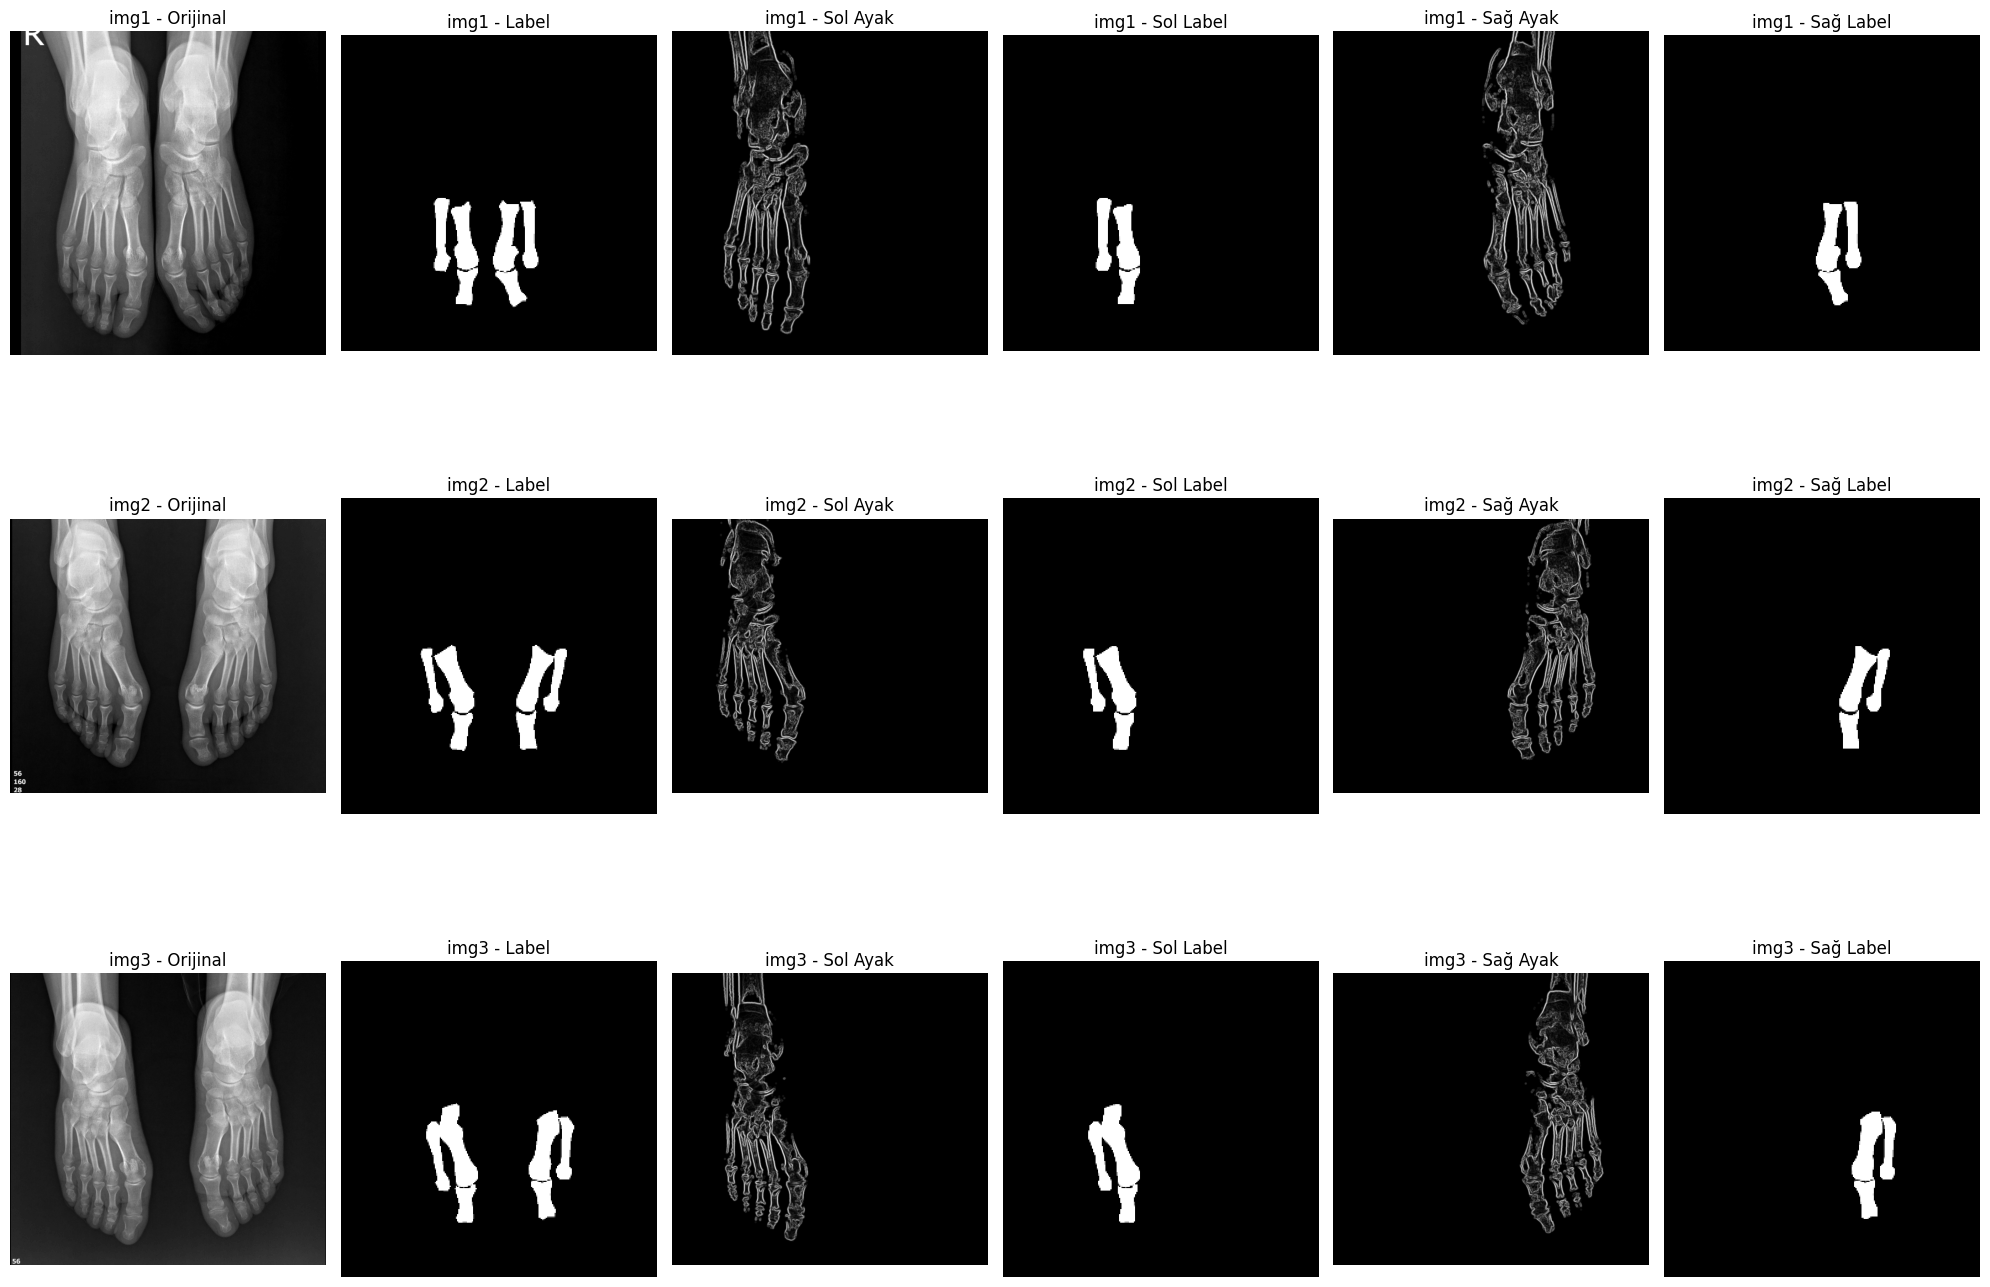


img1 Sonuçları:
Sol Ayak Sobel (k=7) Ortalama: 9.94
Sağ Ayak Sobel (k=7) Ortalama: 9.53
Sol Label Ortalama: 6.26
Sağ Label Ortalama: 6.24

img2 Sonuçları:
Sol Ayak Sobel (k=7) Ortalama: 7.49
Sağ Ayak Sobel (k=7) Ortalama: 8.18
Sol Label Ortalama: 6.26
Sağ Label Ortalama: 6.07

img3 Sonuçları:
Sol Ayak Sobel (k=7) Ortalama: 7.94
Sağ Ayak Sobel (k=7) Ortalama: 7.95
Sol Label Ortalama: 7.26
Sağ Label Ortalama: 6.46


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology
from skimage.util import img_as_ubyte
%matplotlib inline

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def preprocess_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    enhanced = apply_clahe(gray)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5,5), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    return opening, enhanced

def find_feet_contours(processed_image):
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    return contours

def separate_feet(image, processed, enhanced):
    contours = find_feet_contours(processed)

    if len(contours) == 2:
        mask1 = np.zeros_like(processed)
        mask2 = np.zeros_like(processed)

        cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
        cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

        foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
        foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

        M1 = cv2.moments(contours[0])
        M2 = cv2.moments(contours[1])

        if M1['m00'] != 0 and M2['m00'] != 0:
            cx1 = int(M1['m10']/M1['m00'])
            cx2 = int(M2['m10']/M2['m00'])

            if cx1 < cx2:
                left_foot = foot1
                right_foot = foot2
            else:
                left_foot = foot2
                right_foot = foot1

            return left_foot, right_foot

    height, width = enhanced.shape[:2]
    left_foot = enhanced[:, :width//2]
    right_foot = enhanced[:, width//2:]

    return left_foot, right_foot

def minmax_norm(image):
    """MinMax normalizasyon"""
    image_float = image.astype(float)
    min_val = np.min(image_float)
    max_val = np.max(image_float)
    if max_val != min_val:
        normalized = (image_float - min_val) / (max_val - min_val) * 255
    else:
        normalized = image_float
    return normalized.astype(np.uint8)

def optimal_image_enhancement(image):
    normalized = minmax_norm(image)
    gaussian = cv2.GaussianBlur(normalized, (3,3), 0.3)
    enhanced_base = cv2.convertScaleAbs(gaussian, alpha=1.05, beta=0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_clahe = clahe.apply(enhanced_base)

    _, threshold = cv2.threshold(enhanced_clahe, 140, 255, cv2.THRESH_TOZERO)

    return threshold

def apply_sobel_k7(image):
    """Sadece Sobel k=7 uygula"""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=7)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=7)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return sobel

# Ana işlem
# Görüntüleri ve labelları oku
images = {
    'img1': cv2.imread('img1.png', cv2.IMREAD_GRAYSCALE),
    'img2': cv2.imread('img2.png', cv2.IMREAD_GRAYSCALE),
    'img3': cv2.imread('img3.png', cv2.IMREAD_GRAYSCALE)
}

labels = {
    'label1': cv2.imread('label1.png', cv2.IMREAD_GRAYSCALE),
    'label2': cv2.imread('label2.png', cv2.IMREAD_GRAYSCALE),
    'label3': cv2.imread('label3.png', cv2.IMREAD_GRAYSCALE)
}

results = {}

# Her görüntü için işlem yap
for (img_name, image), (label_name, label) in zip(images.items(), labels.items()):
    # İşlem adımları
    processed, enhanced = preprocess_image(image)
    left_foot, right_foot = separate_feet(image, processed, enhanced)

    left_threshold = optimal_image_enhancement(left_foot)
    right_threshold = optimal_image_enhancement(right_foot)

    left_sobel = apply_sobel_k7(left_threshold)
    right_sobel = apply_sobel_k7(right_threshold)

    # Label görüntülerini de ayır
    processed_label, enhanced_label = preprocess_image(label)
    left_label, right_label = separate_feet(label, processed_label, enhanced_label)

    results[img_name] = {
        'left': left_sobel,
        'right': right_sobel,
        'original': image,
        'left_label': left_label,
        'right_label': right_label,
        'original_label': label
    }

# Görselleştirme
plt.figure(figsize=(20, 15))

# Her görüntü için sonuçları göster
for idx, (img_name, result) in enumerate(results.items()):
    # Orijinal görüntü
    plt.subplot(3, 6, idx*6 + 1)
    plt.imshow(result['original'], cmap='gray')
    plt.title(f'{img_name} - Orijinal')
    plt.axis('off')

    # Orijinal label
    plt.subplot(3, 6, idx*6 + 2)
    plt.imshow(result['original_label'], cmap='gray')
    plt.title(f'{img_name} - Label')
    plt.axis('off')

    # Sol ayak
    plt.subplot(3, 6, idx*6 + 3)
    plt.imshow(result['left'], cmap='gray')
    plt.title(f'{img_name} - Sol Ayak')
    plt.axis('off')

    # Sol ayak label
    plt.subplot(3, 6, idx*6 + 4)
    plt.imshow(result['left_label'], cmap='gray')
    plt.title(f'{img_name} - Sol Label')
    plt.axis('off')

    # Sağ ayak
    plt.subplot(3, 6, idx*6 + 5)
    plt.imshow(result['right'], cmap='gray')
    plt.title(f'{img_name} - Sağ Ayak')
    plt.axis('off')

    # Sağ ayak label
    plt.subplot(3, 6, idx*6 + 6)
    plt.imshow(result['right_label'], cmap='gray')
    plt.title(f'{img_name} - Sağ Label')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Sonuçları kaydet
for img_name, result in results.items():
    cv2.imwrite(f'{img_name}_original.png', result['original'])
    cv2.imwrite(f'{img_name}_original_label.png', result['original_label'])
    cv2.imwrite(f'{img_name}_left.png', result['left'])
    cv2.imwrite(f'{img_name}_left_label.png', result['left_label'])
    cv2.imwrite(f'{img_name}_right.png', result['right'])
    cv2.imwrite(f'{img_name}_right_label.png', result['right_label'])

# Ortalama değerleri yazdır
for img_name, result in results.items():
    print(f"\n{img_name} Sonuçları:")
    print(f"Sol Ayak Sobel (k=7) Ortalama: {np.mean(result['left']):.2f}")
    print(f"Sağ Ayak Sobel (k=7) Ortalama: {np.mean(result['right']):.2f}")
    print(f"Sol Label Ortalama: {np.mean(result['left_label']):.2f}")
    print(f"Sağ Label Ortalama: {np.mean(result['right_label']):.2f}")

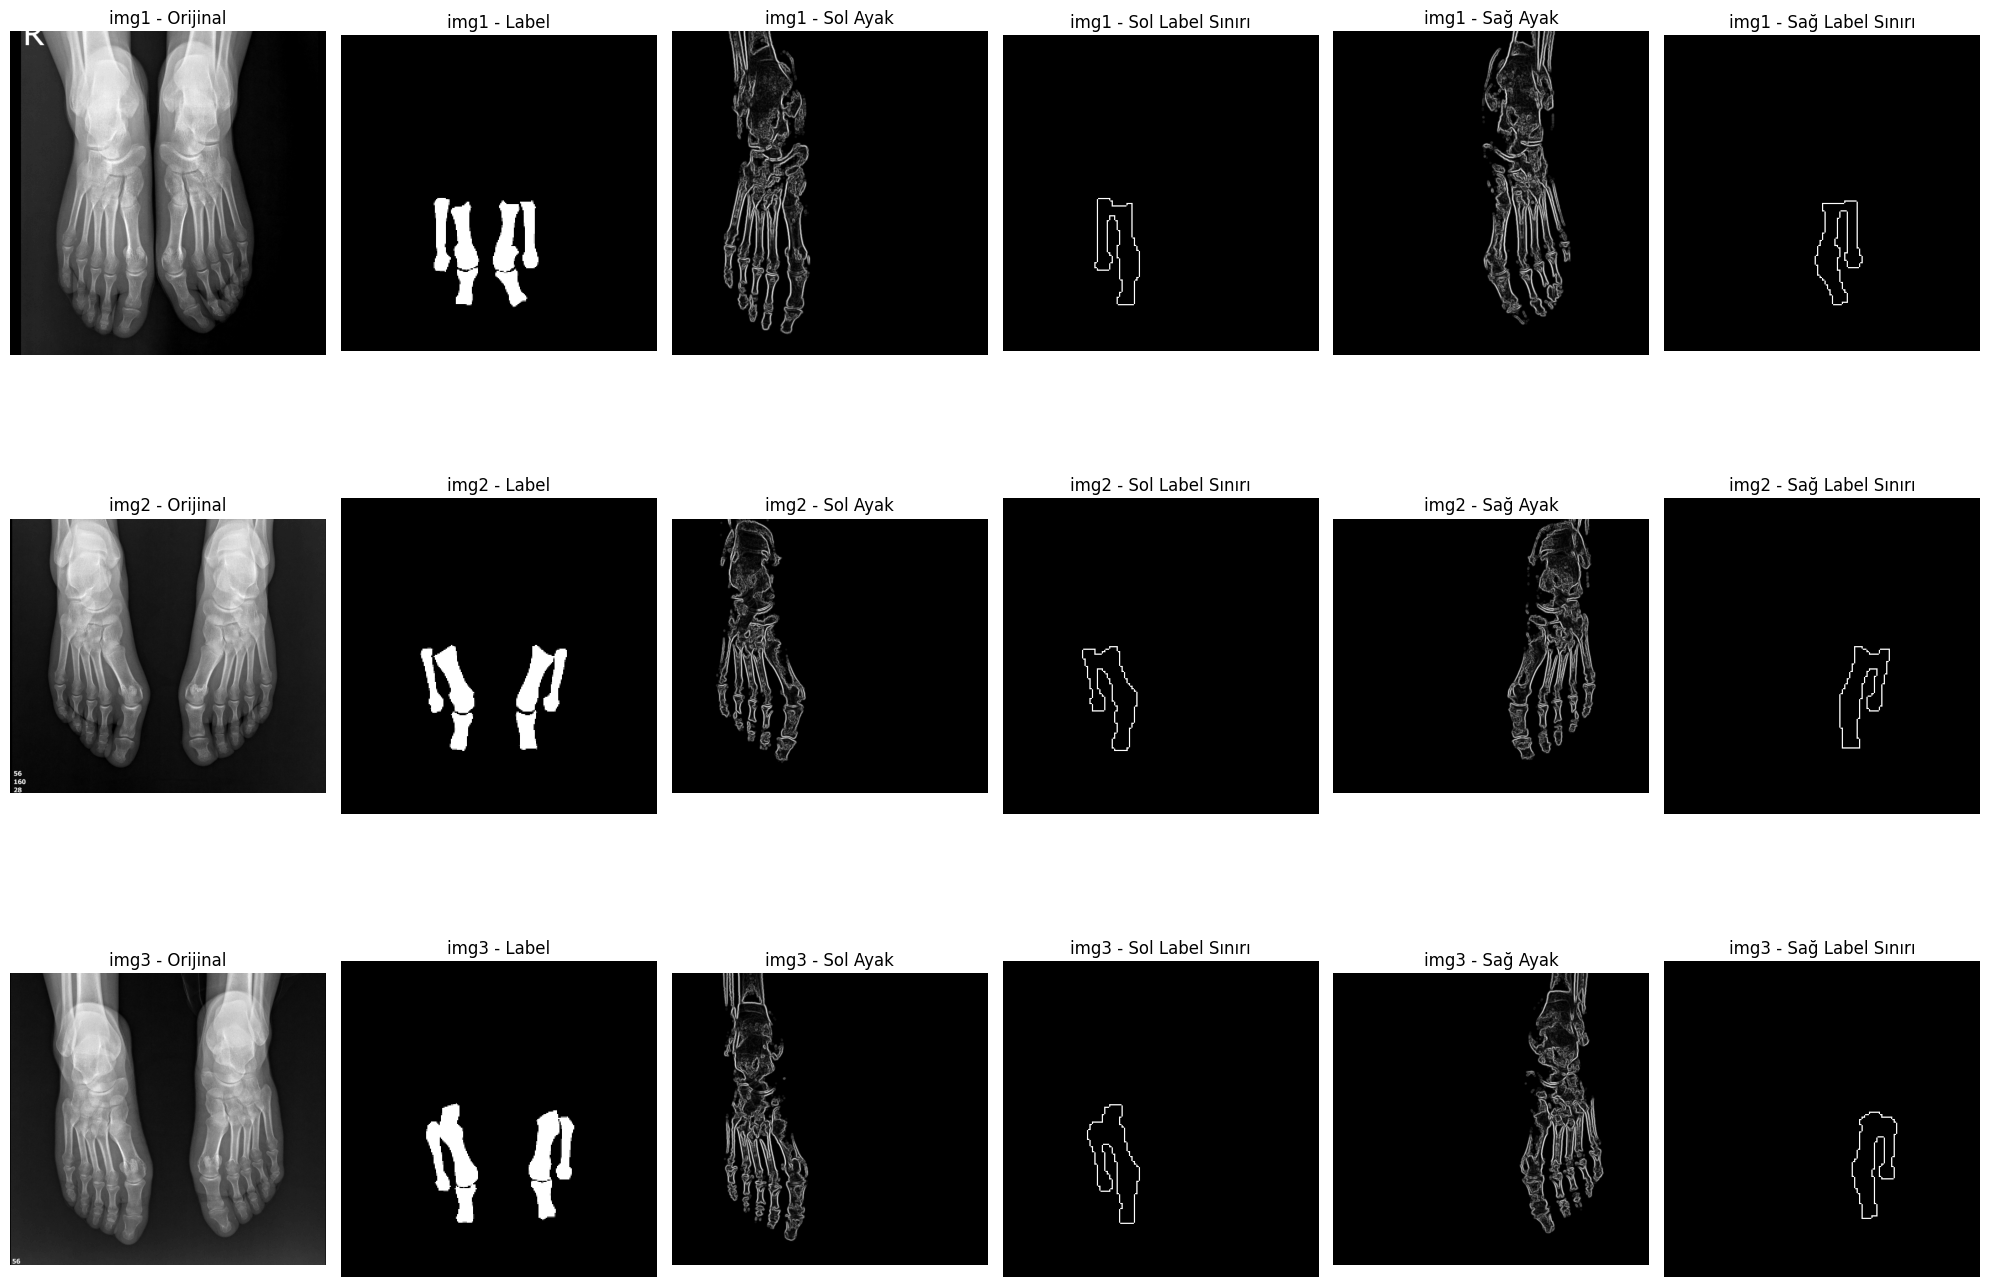


img1 Sonuçları:
Sol Ayak Sobel (k=7) Ortalama: 9.94
Sağ Ayak Sobel (k=7) Ortalama: 9.53
Sol Label Sınır Ortalama: 1.29
Sağ Label Sınır Ortalama: 1.31

img2 Sonuçları:
Sol Ayak Sobel (k=7) Ortalama: 7.49
Sağ Ayak Sobel (k=7) Ortalama: 8.18
Sol Label Sınır Ortalama: 1.26
Sağ Label Sınır Ortalama: 1.21

img3 Sonuçları:
Sol Ayak Sobel (k=7) Ortalama: 7.94
Sağ Ayak Sobel (k=7) Ortalama: 7.95
Sol Label Sınır Ortalama: 1.32
Sağ Label Sınır Ortalama: 1.19


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology, measure
from skimage.util import img_as_ubyte
%matplotlib inline

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def preprocess_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    enhanced = apply_clahe(gray)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5,5), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    return opening, enhanced

def find_feet_contours(processed_image):
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    return contours

def separate_feet(image, processed, enhanced):
    contours = find_feet_contours(processed)

    if len(contours) == 2:
        mask1 = np.zeros_like(processed)
        mask2 = np.zeros_like(processed)

        cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
        cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

        foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
        foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

        M1 = cv2.moments(contours[0])
        M2 = cv2.moments(contours[1])

        if M1['m00'] != 0 and M2['m00'] != 0:
            cx1 = int(M1['m10']/M1['m00'])
            cx2 = int(M2['m10']/M2['m00'])

            if cx1 < cx2:
                left_foot = foot1
                right_foot = foot2
            else:
                left_foot = foot2
                right_foot = foot1

            return left_foot, right_foot

    height, width = enhanced.shape[:2]
    left_foot = enhanced[:, :width//2]
    right_foot = enhanced[:, width//2:]

    return left_foot, right_foot

def minmax_norm(image):
    """MinMax normalizasyon"""
    image_float = image.astype(float)
    min_val = np.min(image_float)
    max_val = np.max(image_float)
    if max_val != min_val:
        normalized = (image_float - min_val) / (max_val - min_val) * 255
    else:
        normalized = image_float
    return normalized.astype(np.uint8)

def optimal_image_enhancement(image):
    normalized = minmax_norm(image)
    gaussian = cv2.GaussianBlur(normalized, (3,3), 0.3)
    enhanced_base = cv2.convertScaleAbs(gaussian, alpha=1.05, beta=0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_clahe = clahe.apply(enhanced_base)

    _, threshold = cv2.threshold(enhanced_clahe, 140, 255, cv2.THRESH_TOZERO)

    return threshold

def apply_sobel_k7(image):
    """Sadece Sobel k=7 uygula"""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=7)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=7)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return sobel

def get_boundary(label_image):
    """
    Label görüntüsünün sınırlarını bwboundary benzeri şekilde çıkarır
    """
    # Binary görüntüye çevir
    binary = label_image > 0

    # Contour'ları bul
    contours = measure.find_contours(binary, 0.5)

    # Boş bir görüntü oluştur
    boundary_image = np.zeros_like(label_image, dtype=np.uint8)

    # Contour'ları çiz
    for contour in contours:
        # Koordinatları integer'a çevir
        coords = np.round(contour).astype(int)
        # Sınırları çiz
        for x, y in coords:
            if 0 <= x < boundary_image.shape[0] and 0 <= y < boundary_image.shape[1]:
                boundary_image[x, y] = 255

    return boundary_image

# Ana işlem
# Görüntüleri ve labelları oku
images = {
    'img1': cv2.imread('img1.png', cv2.IMREAD_GRAYSCALE),
    'img2': cv2.imread('img2.png', cv2.IMREAD_GRAYSCALE),
    'img3': cv2.imread('img3.png', cv2.IMREAD_GRAYSCALE)
}

labels = {
    'label1': cv2.imread('label1.png', cv2.IMREAD_GRAYSCALE),
    'label2': cv2.imread('label2.png', cv2.IMREAD_GRAYSCALE),
    'label3': cv2.imread('label3.png', cv2.IMREAD_GRAYSCALE)
}

results = {}

# Her görüntü için işlem yap
for (img_name, image), (label_name, label) in zip(images.items(), labels.items()):
    # İşlem adımları
    processed, enhanced = preprocess_image(image)
    left_foot, right_foot = separate_feet(image, processed, enhanced)

    left_threshold = optimal_image_enhancement(left_foot)
    right_threshold = optimal_image_enhancement(right_foot)

    left_sobel = apply_sobel_k7(left_threshold)
    right_sobel = apply_sobel_k7(right_threshold)

    # Label görüntülerini ayır ve sınırları bul
    processed_label, enhanced_label = preprocess_image(label)
    left_label, right_label = separate_feet(label, processed_label, enhanced_label)

    # Label sınırlarını çıkar
    left_label_boundary = get_boundary(left_label)
    right_label_boundary = get_boundary(right_label)

    results[img_name] = {
        'left': left_sobel,
        'right': right_sobel,
        'original': image,
        'left_label': left_label_boundary,
        'right_label': right_label_boundary,
        'original_label': label
    }

# Görselleştirme
plt.figure(figsize=(20, 15))

# Her görüntü için sonuçları göster
for idx, (img_name, result) in enumerate(results.items()):
    # Orijinal görüntü
    plt.subplot(3, 6, idx*6 + 1)
    plt.imshow(result['original'], cmap='gray')
    plt.title(f'{img_name} - Orijinal')
    plt.axis('off')

    # Orijinal label
    plt.subplot(3, 6, idx*6 + 2)
    plt.imshow(result['original_label'], cmap='gray')
    plt.title(f'{img_name} - Label')
    plt.axis('off')

    # Sol ayak
    plt.subplot(3, 6, idx*6 + 3)
    plt.imshow(result['left'], cmap='gray')
    plt.title(f'{img_name} - Sol Ayak')
    plt.axis('off')

    # Sol ayak label sınırı
    plt.subplot(3, 6, idx*6 + 4)
    plt.imshow(result['left_label'], cmap='gray')
    plt.title(f'{img_name} - Sol Label Sınırı')
    plt.axis('off')

    # Sağ ayak
    plt.subplot(3, 6, idx*6 + 5)
    plt.imshow(result['right'], cmap='gray')
    plt.title(f'{img_name} - Sağ Ayak')
    plt.axis('off')

    # Sağ ayak label sınırı
    plt.subplot(3, 6, idx*6 + 6)
    plt.imshow(result['right_label'], cmap='gray')
    plt.title(f'{img_name} - Sağ Label Sınırı')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Sonuçları kaydet
for img_name, result in results.items():
    cv2.imwrite(f'{img_name}_original.png', result['original'])
    cv2.imwrite(f'{img_name}_original_label.png', result['original_label'])
    cv2.imwrite(f'{img_name}_left.png', result['left'])
    cv2.imwrite(f'{img_name}_left_label_boundary.png', result['left_label'])
    cv2.imwrite(f'{img_name}_right.png', result['right'])
    cv2.imwrite(f'{img_name}_right_label_boundary.png', result['right_label'])

# Ortalama değerleri yazdır
for img_name, result in results.items():
    print(f"\n{img_name} Sonuçları:")
    print(f"Sol Ayak Sobel (k=7) Ortalama: {np.mean(result['left']):.2f}")
    print(f"Sağ Ayak Sobel (k=7) Ortalama: {np.mean(result['right']):.2f}")
    print(f"Sol Label Sınır Ortalama: {np.mean(result['left_label']):.2f}")
    print(f"Sağ Label Sınır Ortalama: {np.mean(result['right_label']):.2f}")

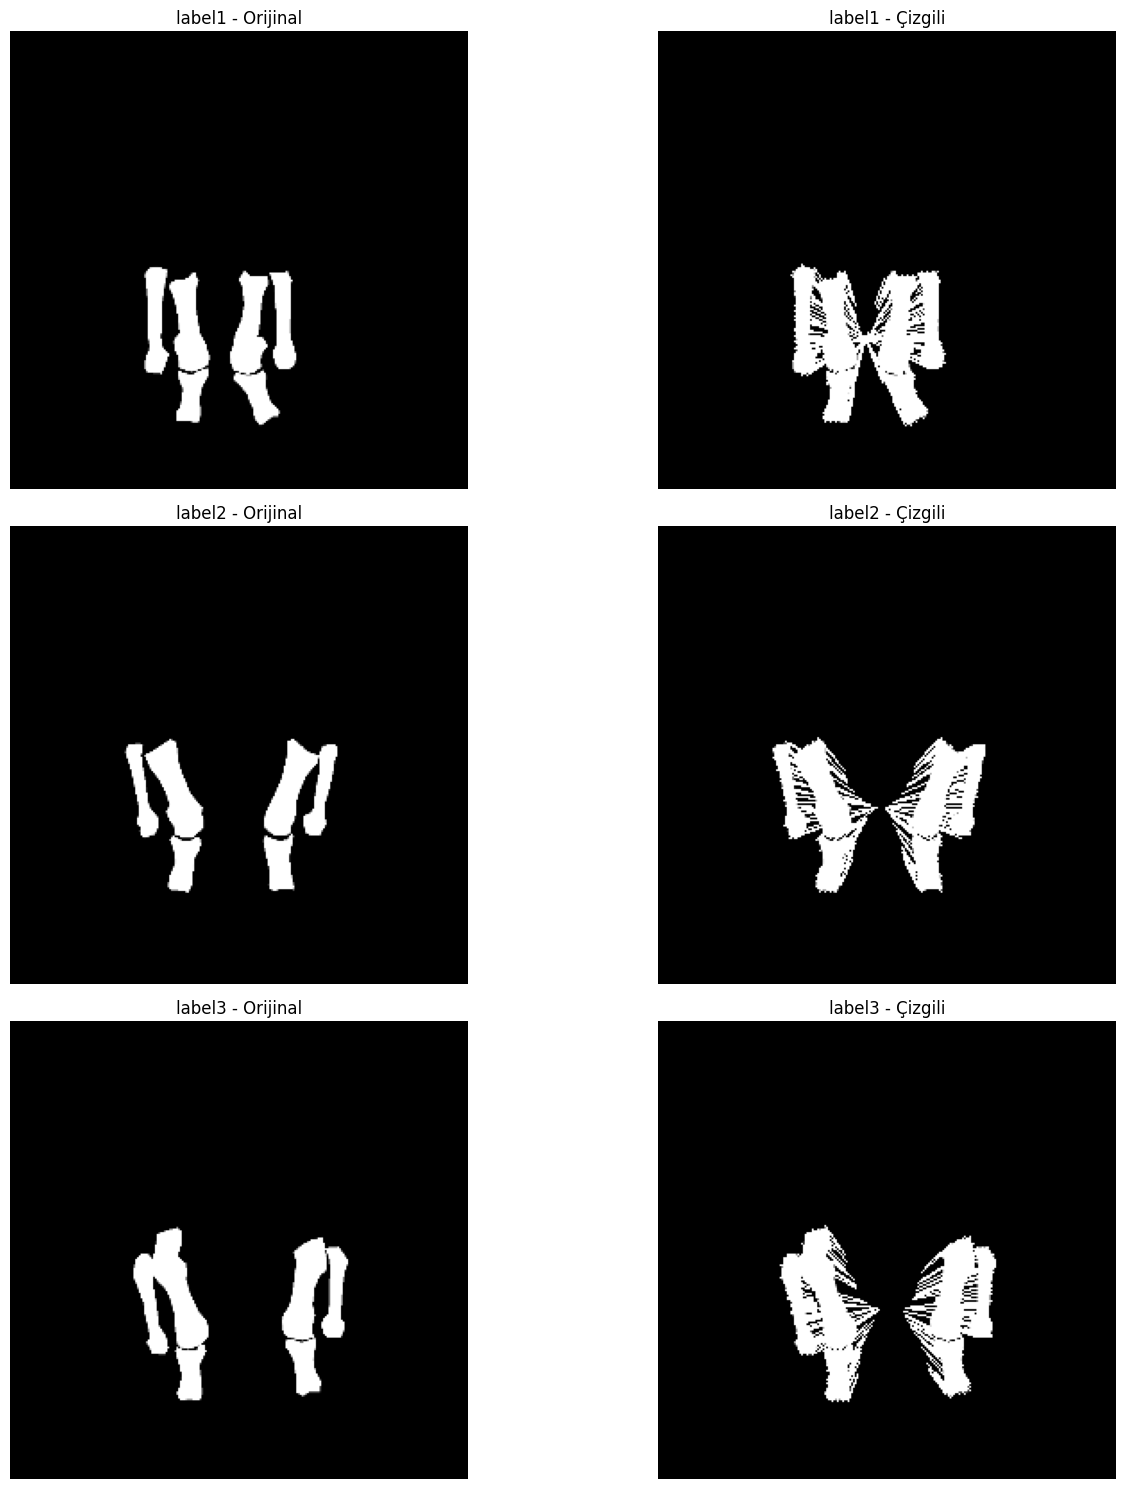


label1 Sonuçları:
Orijinal Ortalama: 12.68
Çizgili Label Ortalama: 16.88

label2 Sonuçları:
Orijinal Ortalama: 12.46
Çizgili Label Ortalama: 17.47

label3 Sonuçları:
Orijinal Ortalama: 13.81
Çizgili Label Ortalama: 18.84


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology, measure
from skimage.util import img_as_ubyte
%matplotlib inline

def get_boundary(label_image):
    """
    Label görüntüsünün sınırlarını bwboundary benzeri şekilde çıkarır
    """
    binary = label_image > 0
    contours = measure.find_contours(binary, 0.5)
    boundary_image = np.zeros_like(label_image, dtype=np.uint8)

    for contour in contours:
        coords = np.round(contour).astype(int)
        for x, y in coords:
            if 0 <= x < boundary_image.shape[0] and 0 <= y < boundary_image.shape[1]:
                boundary_image[x, y] = 255

    return boundary_image

def find_center(label_image):
    """
    Label görüntüsünün merkez noktasını bulur
    """
    binary = label_image > 0
    M = cv2.moments(binary.astype(np.uint8))
    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        center_x = label_image.shape[1] // 2
        center_y = label_image.shape[0] // 2
    return center_x, center_y

def draw_lines_from_boundary(label_image, boundary_image, line_length=15, step_size=3):
    """
    Label görüntüsü üzerine merkeze doğru çizgiler çizer
    """
    y_coords, x_coords = np.where(boundary_image == 255)

    # Merkez noktasını bul
    center_x, center_y = find_center(label_image)

    # Koordinatları step_size'a göre seyrelt
    coords = list(zip(y_coords, x_coords))[::step_size]

    # Label görüntüsünün kopyasını al
    result_image = label_image.copy()

    for y, x in coords:
        # Merkeze olan vektörü hesapla
        dx = center_x - x
        dy = center_y - y

        # Vektörün uzunluğunu normalize et
        length = np.sqrt(dx*dx + dy*dy)
        if length > 0:
            dx = dx / length
            dy = dy / length

            # İç noktayı hesapla
            x2 = int(x + dx * line_length)
            y2 = int(y + dy * line_length)

            # Görüntü sınırları içinde kalmasını sağla
            height, width = boundary_image.shape
            x2 = np.clip(x2, 0, width-1)
            y2 = np.clip(y2, 0, height-1)

            # Çizgiyi çiz
            cv2.line(result_image, (x, y), (x2, y2), 255, 1)

    return result_image

# Ana işlem
# Label görüntülerini oku
labels = {
    'label1': cv2.imread('label1.png', cv2.IMREAD_GRAYSCALE),
    'label2': cv2.imread('label2.png', cv2.IMREAD_GRAYSCALE),
    'label3': cv2.imread('label3.png', cv2.IMREAD_GRAYSCALE)
}

results = {}

# Her label için işlem yap
for label_name, label in labels.items():
    # Label sınırlarını çıkar
    boundary = get_boundary(label)

    # Sınırlardan çizgileri label üzerine çiz
    lines_on_label = draw_lines_from_boundary(label, boundary, line_length=15, step_size=3)

    results[label_name] = {
        'original': label,
        'boundary': boundary,
        'lines_on_label': lines_on_label
    }

# Görselleştirme
plt.figure(figsize=(15, 15))

# Her label için sonuçları göster
for idx, (label_name, result) in enumerate(results.items()):
    # Orijinal label
    plt.subplot(3, 2, idx*2 + 1)
    plt.imshow(result['original'], cmap='gray')
    plt.title(f'{label_name} - Orijinal')
    plt.axis('off')

    # Label üzerinde çizgiler
    plt.subplot(3, 2, idx*2 + 2)
    plt.imshow(result['lines_on_label'], cmap='gray')
    plt.title(f'{label_name} - Çizgili')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Sonuçları kaydet
for label_name, result in results.items():
    cv2.imwrite(f'{label_name}_original.png', result['original'])
    cv2.imwrite(f'{label_name}_lines_on_label.png', result['lines_on_label'])

# Ortalama değerleri yazdır
for label_name, result in results.items():
    print(f"\n{label_name} Sonuçları:")
    print(f"Orijinal Ortalama: {np.mean(result['original']):.2f}")
    print(f"Çizgili Label Ortalama: {np.mean(result['lines_on_label']):.2f}")

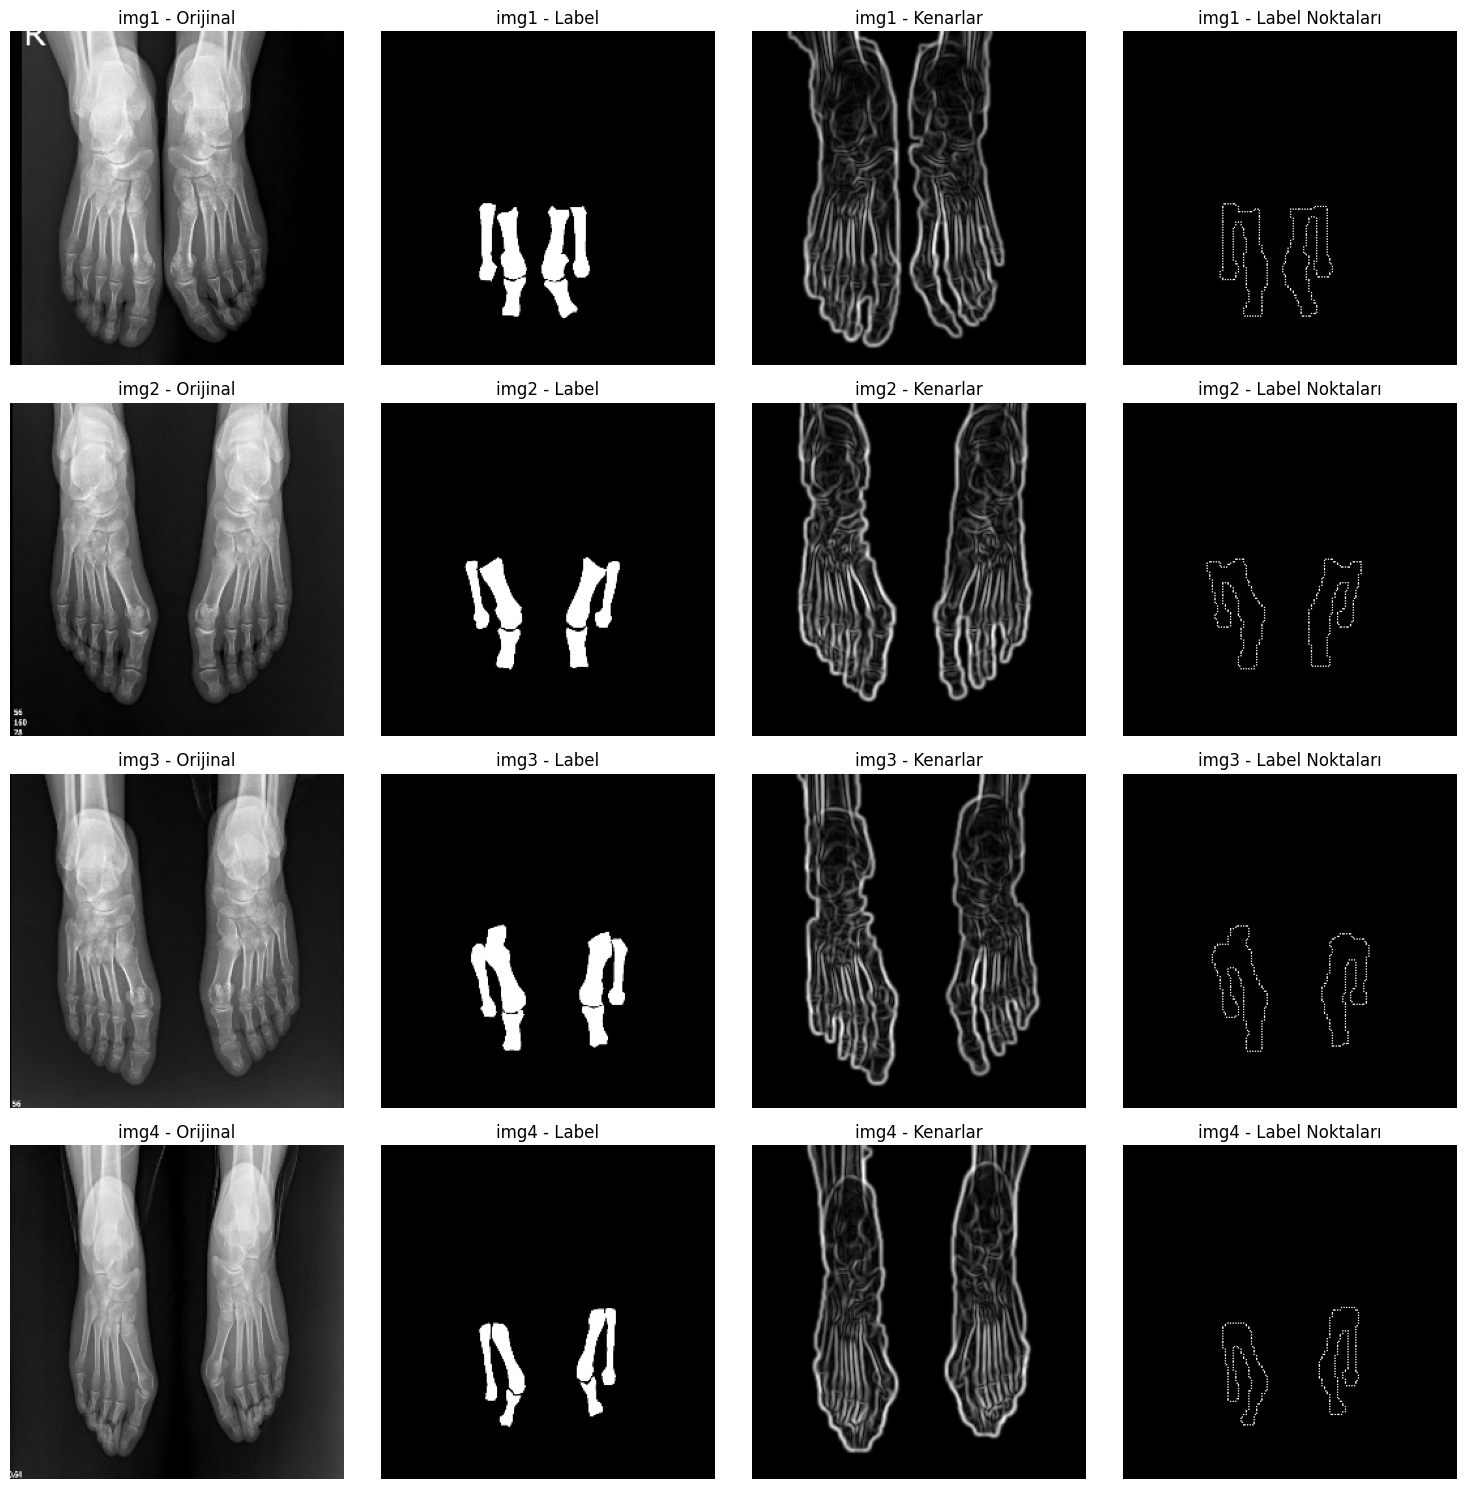

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology, measure
from skimage.util import img_as_ubyte
%matplotlib inline

def get_boundary(label_image):
    """
    Label görüntüsünün sınırlarını bwboundary benzeri şekilde çıkarır
    """
    binary = label_image > 0
    contours = measure.find_contours(binary, 0.5)
    boundary_image = np.zeros_like(label_image, dtype=np.uint8)

    boundary_points = []
    for contour in contours:
        coords = np.round(contour).astype(int)
        for x, y in coords:
            if 0 <= x < boundary_image.shape[0] and 0 <= y < boundary_image.shape[1]:
                boundary_image[x, y] = 255
                boundary_points.append((x, y))

    return boundary_image, boundary_points

def generate_points_on_boundary(boundary_points, step_size=5):
    """
    Sınır noktaları üzerinde belirli aralıklarla noktalar üretir
    """
    selected_points = boundary_points[::step_size]
    return selected_points

def overlay_points_on_image(original, points, color=(0, 0, 255)):
    """
    Noktaları orijinal görüntü üzerine bindirir
    """
    if len(original.shape) == 2:
        original_bgr = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    else:
        original_bgr = original.copy()

    for x, y in points:
        cv2.circle(original_bgr, (y, x), 2, color, -1)  # x,y koordinatlarını ters çevir

    return original_bgr

# Ana işlem
# Label görüntülerini oku
labels = {
    'label1': cv2.imread('label1.png', cv2.IMREAD_GRAYSCALE),
    'label2': cv2.imread('label2.png', cv2.IMREAD_GRAYSCALE),
    'label3': cv2.imread('label3.png', cv2.IMREAD_GRAYSCALE)
}

results = {}

# Her label için işlem yap
for label_name, label in labels.items():
    # Label sınırlarını ve noktalarını bul
    boundary_image, boundary_points = get_boundary(label)

    # Sınır üzerinde noktalar üret
    selected_points = generate_points_on_boundary(boundary_points, step_size=5)

    # Noktaları görüntü üzerine bindir
    overlay = overlay_points_on_image(label, selected_points)

    results[label_name] = {
        'original': label,
        'boundary': boundary_image,
        'overlay': overlay,
        'points': selected_points
    }

# Görselleştirme
plt.figure(figsize=(15, 15))

# Her label için sonuçları göster
for idx, (label_name, result) in enumerate(results.items()):
    # Orijinal label
    plt.subplot(3, 2, idx*2 + 1)
    plt.imshow(result['original'], cmap='gray')
    plt.title(f'{label_name} - Orijinal')
    plt.axis('off')

    # Noktalı görüntü
    plt.subplot(3, 2, idx*2 + 2)
    plt.imshow(cv2.cvtColor(result['overlay'], cv2.COLOR_BGR2RGB))
    plt.title(f'{label_name} - Sınır Noktaları')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Sonuçları kaydet
for label_name, result in results.items():
    cv2.imwrite(f'{label_name}_original.png', result['original'])
    cv2.imwrite(f'{label_name}_boundary.png', result['boundary'])
    cv2.imwrite(f'{label_name}_overlay.png', result['overlay'])

# Nokta sayılarını yazdır
for label_name, result in results.items():
    print(f"\n{label_name} Sonuçları:")
    print(f"Sınır Nokta Sayısı: {len(result['points'])}")

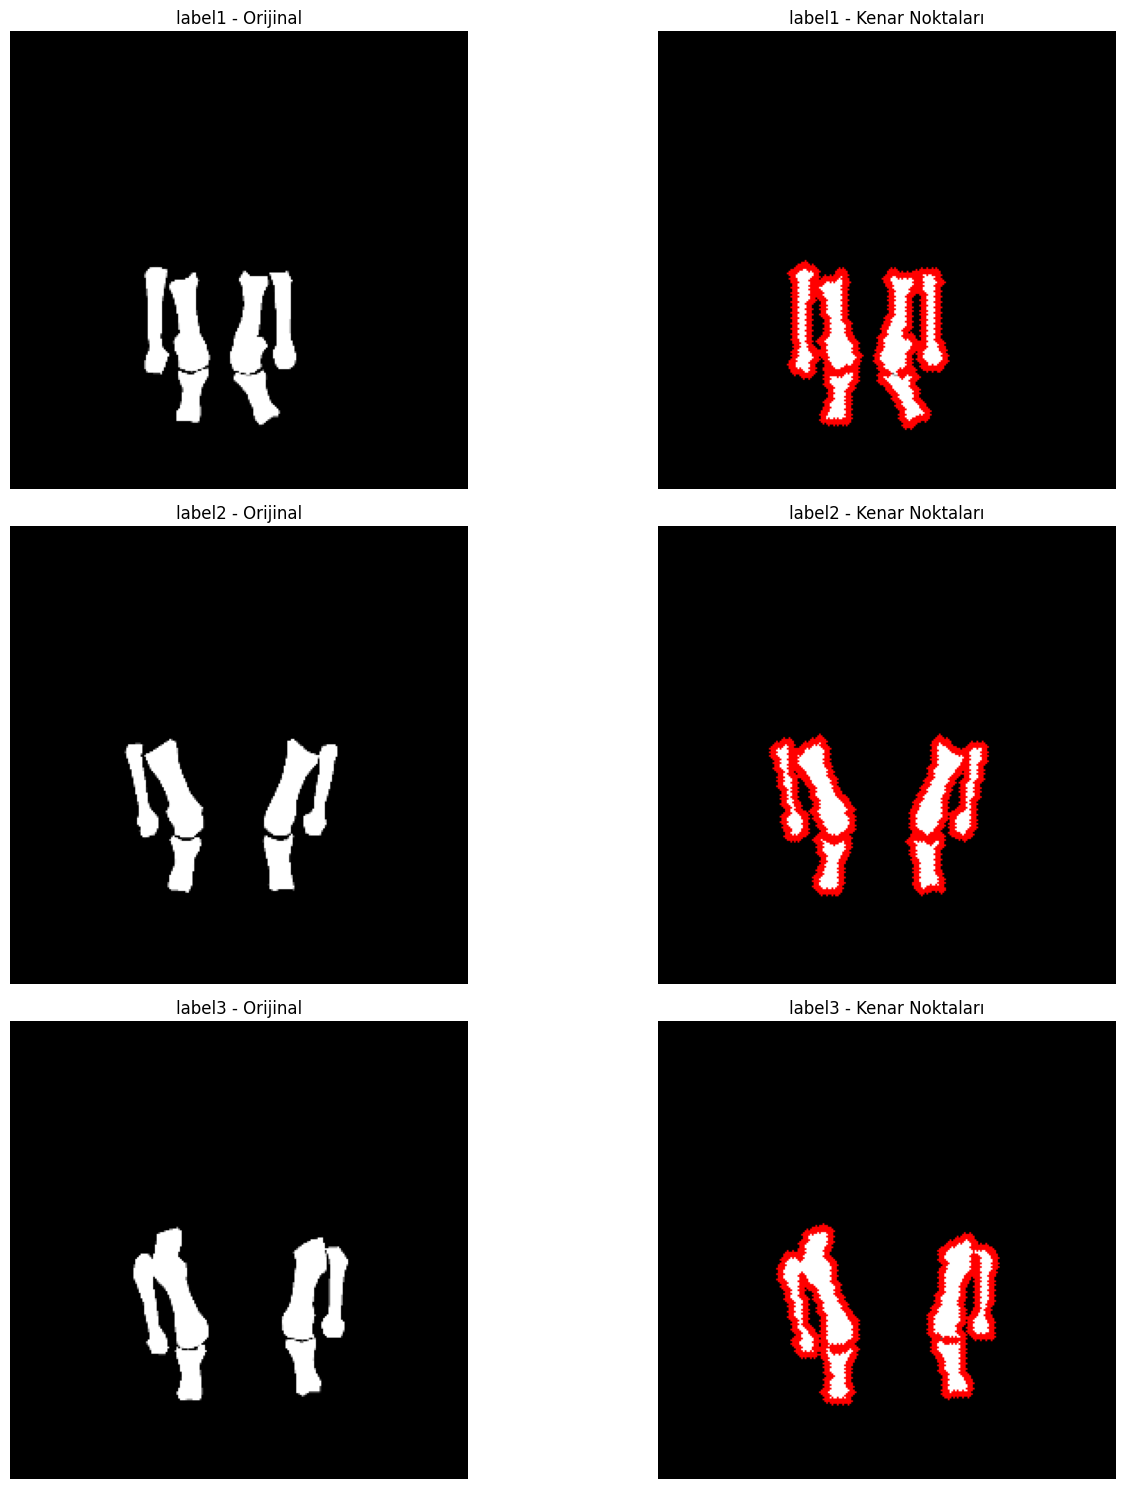


label1 Sonuçları:
Kenar Nokta Sayısı: 287

label2 Sonuçları:
Kenar Nokta Sayısı: 292

label3 Sonuçları:
Kenar Nokta Sayısı: 279


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology, measure
from skimage.util import img_as_ubyte
%matplotlib inline

def get_boundary_points(label_image):
    """
    Label görüntüsünün sınır noktalarını bwboundary benzeri şekilde çıkarır
    """
    binary = label_image > 0
    contours = measure.find_contours(binary, 0.5)

    # Sadece sınır noktalarını tut
    boundary_points = []
    for contour in contours:
        coords = np.round(contour).astype(int)
        for x, y in coords:
            if 0 <= x < label_image.shape[0] and 0 <= y < label_image.shape[1]:
                boundary_points.append((x, y))

    return boundary_points

def create_boundary_points_image(image_shape, boundary_points, step_size=5):
    """
    Sınır noktalarından görüntü oluşturur
    """
    points_image = np.zeros(image_shape, dtype=np.uint8)

    # Belirli aralıklarla noktaları seç
    for i, (x, y) in enumerate(boundary_points):
        if i % step_size == 0:  # Her step_size noktada bir işaretle
            points_image[x, y] = 255

    return points_image

def overlay_points_on_image(original, points_image, color=(0, 0, 255)):
    """
    Noktaları orijinal görüntü üzerine bindirir
    """
    if len(original.shape) == 2:
        original_bgr = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    else:
        original_bgr = original.copy()

    y_coords, x_coords = np.where(points_image == 255)
    for x, y in zip(x_coords, y_coords):
        cv2.circle(original_bgr, (x, y), 2, color, -1)

    return original_bgr

# Ana işlem
# Label görüntülerini oku
labels = {
    'label1': cv2.imread('label1.png', cv2.IMREAD_GRAYSCALE),
    'label2': cv2.imread('label2.png', cv2.IMREAD_GRAYSCALE),
    'label3': cv2.imread('label3.png', cv2.IMREAD_GRAYSCALE)
}

results = {}

# Her label için işlem yap
for label_name, label in labels.items():
    # Sınır noktalarını bul
    boundary_points = get_boundary_points(label)

    # Nokta görüntüsü oluştur
    points_image = create_boundary_points_image(label.shape, boundary_points, step_size=3)

    # Noktaları görüntü üzerine bindir
    overlay = overlay_points_on_image(label, points_image)

    results[label_name] = {
        'original': label,
        'points': points_image,
        'overlay': overlay
    }

# Görselleştirme
plt.figure(figsize=(15, 15))

# Her label için sonuçları göster
for idx, (label_name, result) in enumerate(results.items()):
    # Orijinal label
    plt.subplot(3, 2, idx*2 + 1)
    plt.imshow(result['original'], cmap='gray')
    plt.title(f'{label_name} - Orijinal')
    plt.axis('off')

    # Noktalı görüntü
    plt.subplot(3, 2, idx*2 + 2)
    plt.imshow(cv2.cvtColor(result['overlay'], cv2.COLOR_BGR2RGB))
    plt.title(f'{label_name} - Kenar Noktaları')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Sonuçları kaydet
for label_name, result in results.items():
    cv2.imwrite(f'{label_name}_original.png', result['original'])
    cv2.imwrite(f'{label_name}_points.png', result['points'])
    cv2.imwrite(f'{label_name}_overlay.png', result['overlay'])

# Nokta sayılarını yazdır
for label_name, result in results.items():
    print(f"\n{label_name} Sonuçları:")
    print(f"Kenar Nokta Sayısı: {np.sum(result['points'] > 0)}")

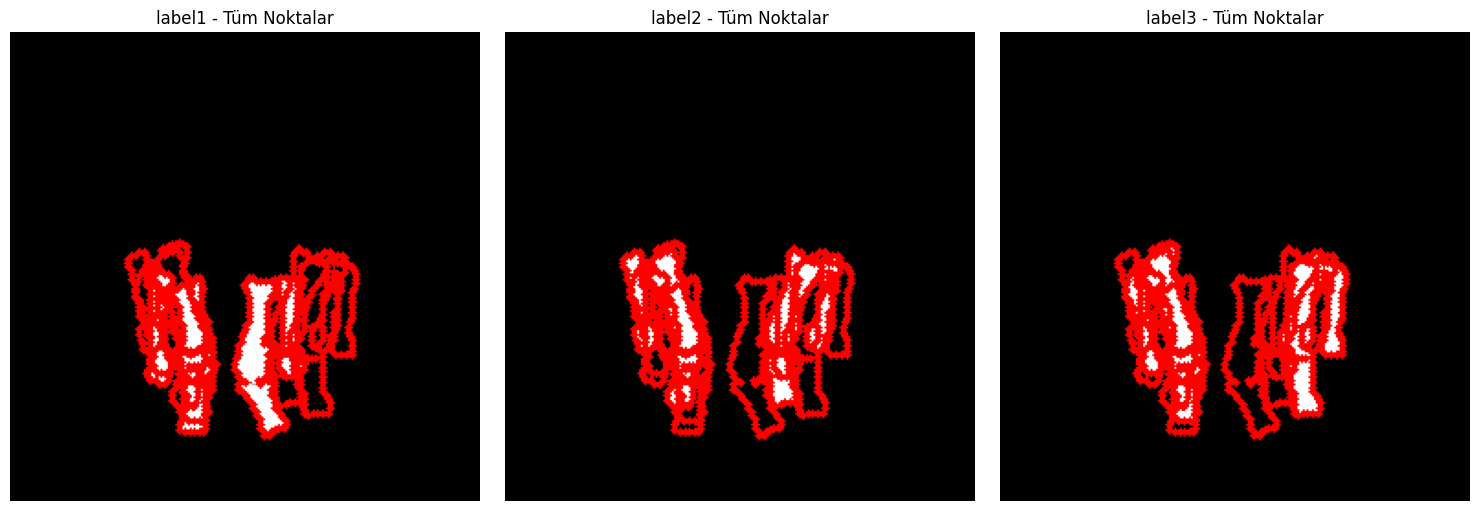

Toplam Nokta Sayısı: 864

M Matrisinin İlk 10 Noktası:
[[192  84]
 [192  81]
 [190  79]
 [190  76]
 [188  75]
 [186  74]
 [184  75]
 [181  76]
 [179  76]
 [176  77]]

M Matrisinin Boyutu: (864, 2)


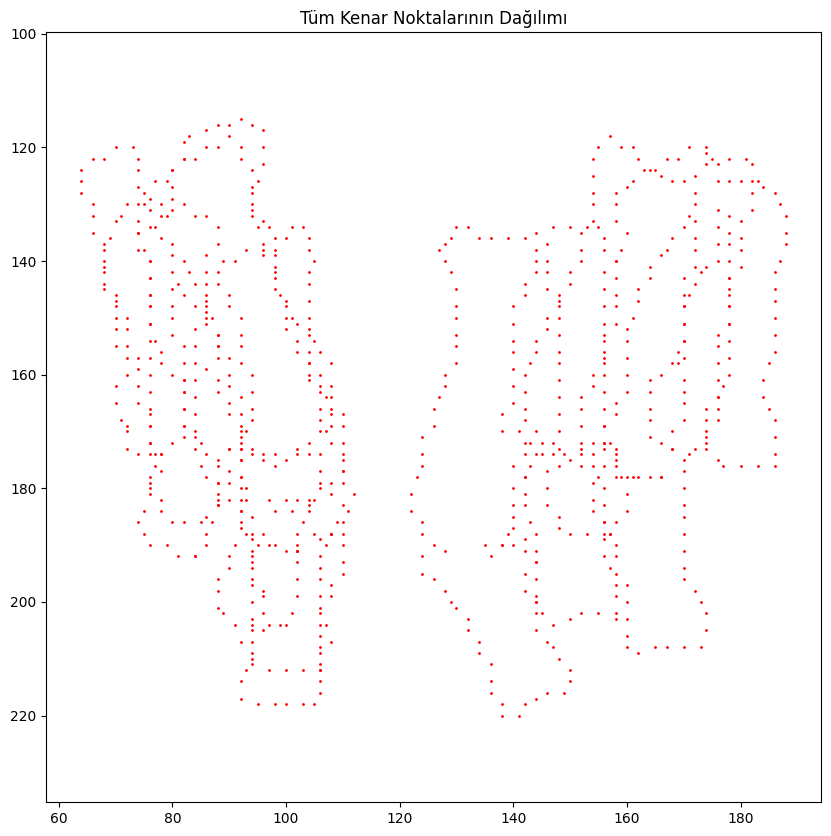

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology, measure
from skimage.util import img_as_ubyte
%matplotlib inline

def get_boundary_points(label_image):
    """
    Label görüntüsünün sınır noktalarını bwboundary benzeri şekilde çıkarır
    """
    binary = label_image > 0
    contours = measure.find_contours(binary, 0.5)

    # Sadece sınır noktalarını tut
    boundary_points = []
    for contour in contours:
        coords = np.round(contour).astype(int)
        for x, y in coords:
            if 0 <= x < label_image.shape[0] and 0 <= y < label_image.shape[1]:
                boundary_points.append((x, y))

    return boundary_points

def create_boundary_points_matrix(image_shape, boundary_points, step_size=5):
    """
    Sınır noktalarından M matrisi oluşturur
    """
    # Her nokta için x, y koordinatlarını tutan matris
    M = []

    # Belirli aralıklarla noktaları seç
    for i, (x, y) in enumerate(boundary_points):
        if i % step_size == 0:  # Her step_size noktada bir işaretle
            M.append([x, y])

    return np.array(M)

def overlay_points_on_image(original, points_matrix, color=(0, 0, 255)):
    """
    M matrisindeki noktaları orijinal görüntü üzerine bindirir
    """
    if len(original.shape) == 2:
        original_bgr = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    else:
        original_bgr = original.copy()

    for point in points_matrix:
        x, y = point
        cv2.circle(original_bgr, (y, x), 2, color, -1)

    return original_bgr

# Ana işlem
# Label görüntülerini oku
labels = {
    'label1': cv2.imread('label1.png', cv2.IMREAD_GRAYSCALE),
    'label2': cv2.imread('label2.png', cv2.IMREAD_GRAYSCALE),
    'label3': cv2.imread('label3.png', cv2.IMREAD_GRAYSCALE)
}

# Tüm noktaları toplayacak ana M matrisi
M_all = []

# Her label için işlem yap
for label_name, label in labels.items():
    # Sınır noktalarını bul
    boundary_points = get_boundary_points(label)

    # M matrisini oluştur
    M = create_boundary_points_matrix(label.shape, boundary_points, step_size=3)

    # Ana M matrisine ekle
    M_all.extend(M)

# M_all'u numpy array'e çevir
M_all = np.array(M_all)

# Sonuçları görselleştir
plt.figure(figsize=(15, 5))

# Her label için orijinal ve noktalı görüntüyü göster
for idx, (label_name, label) in enumerate(labels.items()):
    # Orijinal görüntü üzerine tüm noktaları bindir
    overlay = overlay_points_on_image(label, M_all)

    # Orijinal label
    plt.subplot(1, 3, idx+1)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f'{label_name} - Tüm Noktalar')
    plt.axis('off')

plt.tight_layout()
plt.show()

# M matrisini kaydet
np.save('boundary_points_matrix.npy', M_all)

# Sonuçları yazdır
print(f"Toplam Nokta Sayısı: {len(M_all)}")
print("\nM Matrisinin İlk 10 Noktası:")
print(M_all[:10])
print("\nM Matrisinin Boyutu:", M_all.shape)

# İsteğe bağlı: Noktaların dağılımını göster
plt.figure(figsize=(10, 10))
plt.scatter(M_all[:, 1], M_all[:, 0], c='red', s=1)
plt.title('Tüm Kenar Noktalarının Dağılımı')
plt.axis('equal')
plt.gca().invert_yaxis()  # Görüntü koordinat sistemine uygun olarak y eksenini ters çevir
plt.show()

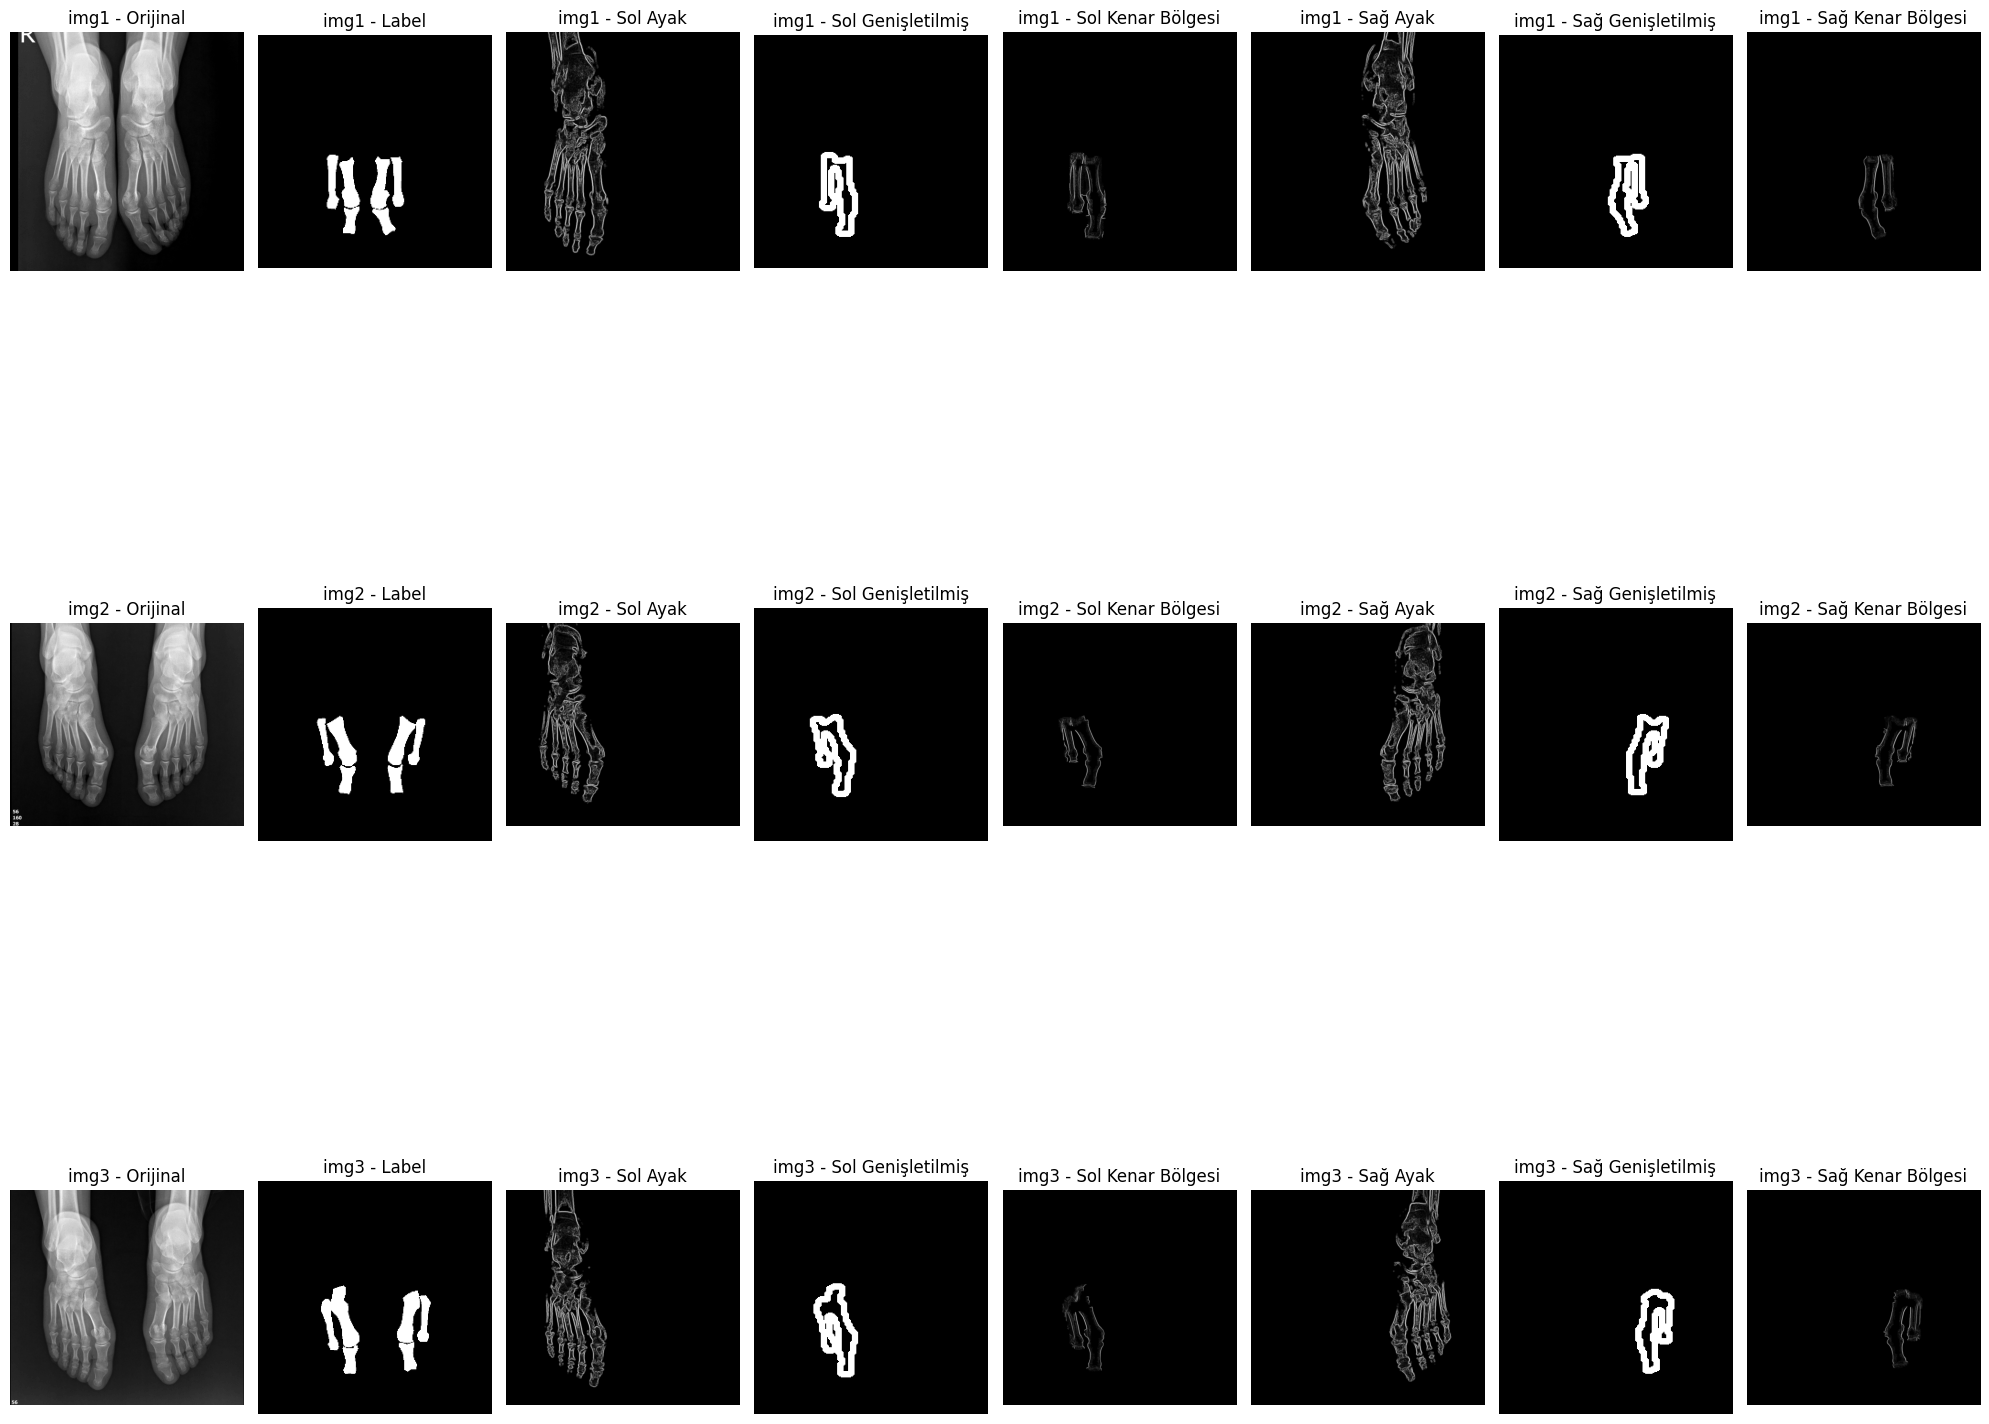


img1 Sonuçları:
Sol Ayak Kenar Bölgesi Ortalama: 1.11
Sağ Ayak Kenar Bölgesi Ortalama: 1.03

img2 Sonuçları:
Sol Ayak Kenar Bölgesi Ortalama: 0.96
Sağ Ayak Kenar Bölgesi Ortalama: 0.96

img3 Sonuçları:
Sol Ayak Kenar Bölgesi Ortalama: 0.90
Sağ Ayak Kenar Bölgesi Ortalama: 0.85


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology, measure
from skimage.util import img_as_ubyte
%matplotlib inline

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def preprocess_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    enhanced = apply_clahe(gray)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5,5), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    return opening, enhanced

def find_feet_contours(processed_image):
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    return contours

def separate_feet(image, processed, enhanced):
    contours = find_feet_contours(processed)

    if len(contours) == 2:
        mask1 = np.zeros_like(processed)
        mask2 = np.zeros_like(processed)

        cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
        cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

        foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
        foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

        M1 = cv2.moments(contours[0])
        M2 = cv2.moments(contours[1])

        if M1['m00'] != 0 and M2['m00'] != 0:
            cx1 = int(M1['m10']/M1['m00'])
            cx2 = int(M2['m10']/M2['m00'])

            if cx1 < cx2:
                left_foot = foot1
                right_foot = foot2
            else:
                left_foot = foot2
                right_foot = foot1

            return left_foot, right_foot

    height, width = enhanced.shape[:2]
    left_foot = enhanced[:, :width//2]
    right_foot = enhanced[:, width//2:]

    return left_foot, right_foot

def minmax_norm(image):
    """MinMax normalizasyon"""
    image_float = image.astype(float)
    min_val = np.min(image_float)
    max_val = np.max(image_float)
    if max_val != min_val:
        normalized = (image_float - min_val) / (max_val - min_val) * 255
    else:
        normalized = image_float
    return normalized.astype(np.uint8)

def optimal_image_enhancement(image):
    normalized = minmax_norm(image)
    gaussian = cv2.GaussianBlur(normalized, (3,3), 0.3)
    enhanced_base = cv2.convertScaleAbs(gaussian, alpha=1.05, beta=0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_clahe = clahe.apply(enhanced_base)

    _, threshold = cv2.threshold(enhanced_clahe, 140, 255, cv2.THRESH_TOZERO)

    return threshold

def apply_sobel_k7(image):
    """Sadece Sobel k=7 uygula"""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=7)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=7)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return sobel

def get_boundary_points(label_image, min_distance=5):
    """
    Label görüntüsünün sınır noktalarını düzenli aralıklarla çıkarır
    """
    binary = label_image > 0
    contours = measure.find_contours(binary, 0.5)

    boundary_points = []
    for contour in contours:
        cumulative_distance = 0
        last_point = None

        for point in contour:
            x, y = np.round(point).astype(int)

            if last_point is None:
                boundary_points.append((x, y))
                last_point = (x, y)
                continue

            distance = np.sqrt((x - last_point[0])**2 + (y - last_point[1])**2)
            cumulative_distance += distance

            if cumulative_distance >= min_distance:
                if 0 <= x < label_image.shape[0] and 0 <= y < label_image.shape[1]:
                    boundary_points.append((x, y))
                cumulative_distance = 0
                last_point = (x, y)

    return np.array(boundary_points)

def get_dilated_boundary(label_image, kernel_size=5):
    """
    Label kenarını dairesel yapısal element ile genişletir
    """
    # Binary görüntüye çevir
    binary = label_image > 0
    boundary = np.zeros_like(label_image)

    # Kenarları bul
    contours = measure.find_contours(binary, 0.5)
    for contour in contours:
        coords = np.round(contour).astype(int)
        for x, y in coords:
            if 0 <= x < boundary.shape[0] and 0 <= y < boundary.shape[1]:
                boundary[x, y] = 255

    # Dairesel yapısal element oluştur
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Genişletme işlemi
    dilated = cv2.dilate(boundary, kernel, iterations=1)

    return dilated

def get_edge_in_dilated_region(image, dilated_boundary):
    """
    Genişletilmiş bölgedeki kenar bilgisini çıkarır
    """
    # Görüntü boyutlarını kontrol et ve eşitle
    if image.shape != dilated_boundary.shape:
        dilated_boundary = cv2.resize(dilated_boundary, (image.shape[1], image.shape[0]))

    # Sobel kenar tespiti
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Normalize et
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Genişletilmiş bölge içindeki kenarları al
    edge_in_region = cv2.bitwise_and(magnitude, dilated_boundary)

    return edge_in_region

# Ana işlem
# Görüntüleri ve labelları oku
images = {
    'img1': cv2.imread('img1.png', cv2.IMREAD_GRAYSCALE),
    'img2': cv2.imread('img2.png', cv2.IMREAD_GRAYSCALE),
    'img3': cv2.imread('img3.png', cv2.IMREAD_GRAYSCALE)
}

labels = {
    'label1': cv2.imread('label1.png', cv2.IMREAD_GRAYSCALE),
    'label2': cv2.imread('label2.png', cv2.IMREAD_GRAYSCALE),
    'label3': cv2.imread('label3.png', cv2.IMREAD_GRAYSCALE)
}

results = {}

# Her görüntü için işlem yap
for (img_name, image), (label_name, label) in zip(images.items(), labels.items()):
    # İşlem adımları
    processed, enhanced = preprocess_image(image)
    left_foot, right_foot = separate_feet(image, processed, enhanced)

    left_threshold = optimal_image_enhancement(left_foot)
    right_threshold = optimal_image_enhancement(right_foot)

    left_sobel = apply_sobel_k7(left_threshold)
    right_sobel = apply_sobel_k7(right_threshold)

    # Label görüntülerini ayır
    processed_label, enhanced_label = preprocess_image(label)
    left_label, right_label = separate_feet(label, processed_label, enhanced_label)

    # Her ayak için genişletilmiş kenarları ve kenar bilgisini hesapla
    left_dilated = get_dilated_boundary(left_label, kernel_size=7)
    right_dilated = get_dilated_boundary(right_label, kernel_size=7)

    left_edge_region = get_edge_in_dilated_region(left_foot, left_dilated)
    right_edge_region = get_edge_in_dilated_region(right_foot, right_dilated)

    results[img_name] = {
        'left': left_sobel,
        'right': right_sobel,
        'original': image,
        'left_label': left_label,
        'right_label': right_label,
        'original_label': label,
        'left_dilated': left_dilated,
        'right_dilated': right_dilated,
        'left_edge_region': left_edge_region,
        'right_edge_region': right_edge_region
    }

# Görselleştirme
plt.figure(figsize=(20, 20))

for idx, (img_name, result) in enumerate(results.items()):
    # Orijinal ve temel sonuçlar
    plt.subplot(3, 8, idx*8 + 1)
    plt.imshow(result['original'], cmap='gray')
    plt.title(f'{img_name} - Orijinal')
    plt.axis('off')

    plt.subplot(3, 8, idx*8 + 2)
    plt.imshow(result['original_label'], cmap='gray')
    plt.title(f'{img_name} - Label')
    plt.axis('off')

    # Sol ayak sonuçları
    plt.subplot(3, 8, idx*8 + 3)
    plt.imshow(result['left'], cmap='gray')
    plt.title(f'{img_name} - Sol Ayak')
    plt.axis('off')

    plt.subplot(3, 8, idx*8 + 4)
    plt.imshow(result['left_dilated'], cmap='gray')
    plt.title(f'{img_name} - Sol Genişletilmiş')
    plt.axis('off')

    plt.subplot(3, 8, idx*8 + 5)
    plt.imshow(result['left_edge_region'], cmap='gray')
    plt.title(f'{img_name} - Sol Kenar Bölgesi')
    plt.axis('off')

    # Sağ ayak sonuçları
    plt.subplot(3, 8, idx*8 + 6)
    plt.imshow(result['right'], cmap='gray')
    plt.title(f'{img_name} - Sağ Ayak')
    plt.axis('off')

    plt.subplot(3, 8, idx*8 + 7)
    plt.imshow(result['right_dilated'], cmap='gray')
    plt.title(f'{img_name} - Sağ Genişletilmiş')
    plt.axis('off')

    plt.subplot(3, 8, idx*8 + 8)
    plt.imshow(result['right_edge_region'], cmap='gray')
    plt.title(f'{img_name} - Sağ Kenar Bölgesi')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Sonuçları kaydet
for img_name, result in results.items():
    cv2.imwrite(f'{img_name}_original.png', result['original'])
    cv2.imwrite(f'{img_name}_original_label.png', result['original_label'])
    cv2.imwrite(f'{img_name}_left.png', result['left'])
    cv2.imwrite(f'{img_name}_right.png', result['right'])
    cv2.imwrite(f'{img_name}_left_dilated.png', result['left_dilated'])
    cv2.imwrite(f'{img_name}_right_dilated.png', result['right_dilated'])
    cv2.imwrite(f'{img_name}_left_edge_region.png', result['left_edge_region'])
    cv2.imwrite(f'{img_name}_right_edge_region.png', result['right_edge_region'])

# Ortalama değerleri yazdır
for img_name, result in results.items():
    print(f"\n{img_name} Sonuçları:")
    print(f"Sol Ayak Kenar Bölgesi Ortalama: {np.mean(result['left_edge_region']):.2f}")
    print(f"Sağ Ayak Kenar Bölgesi Ortalama: {np.mean(result['right_edge_region']):.2f}")

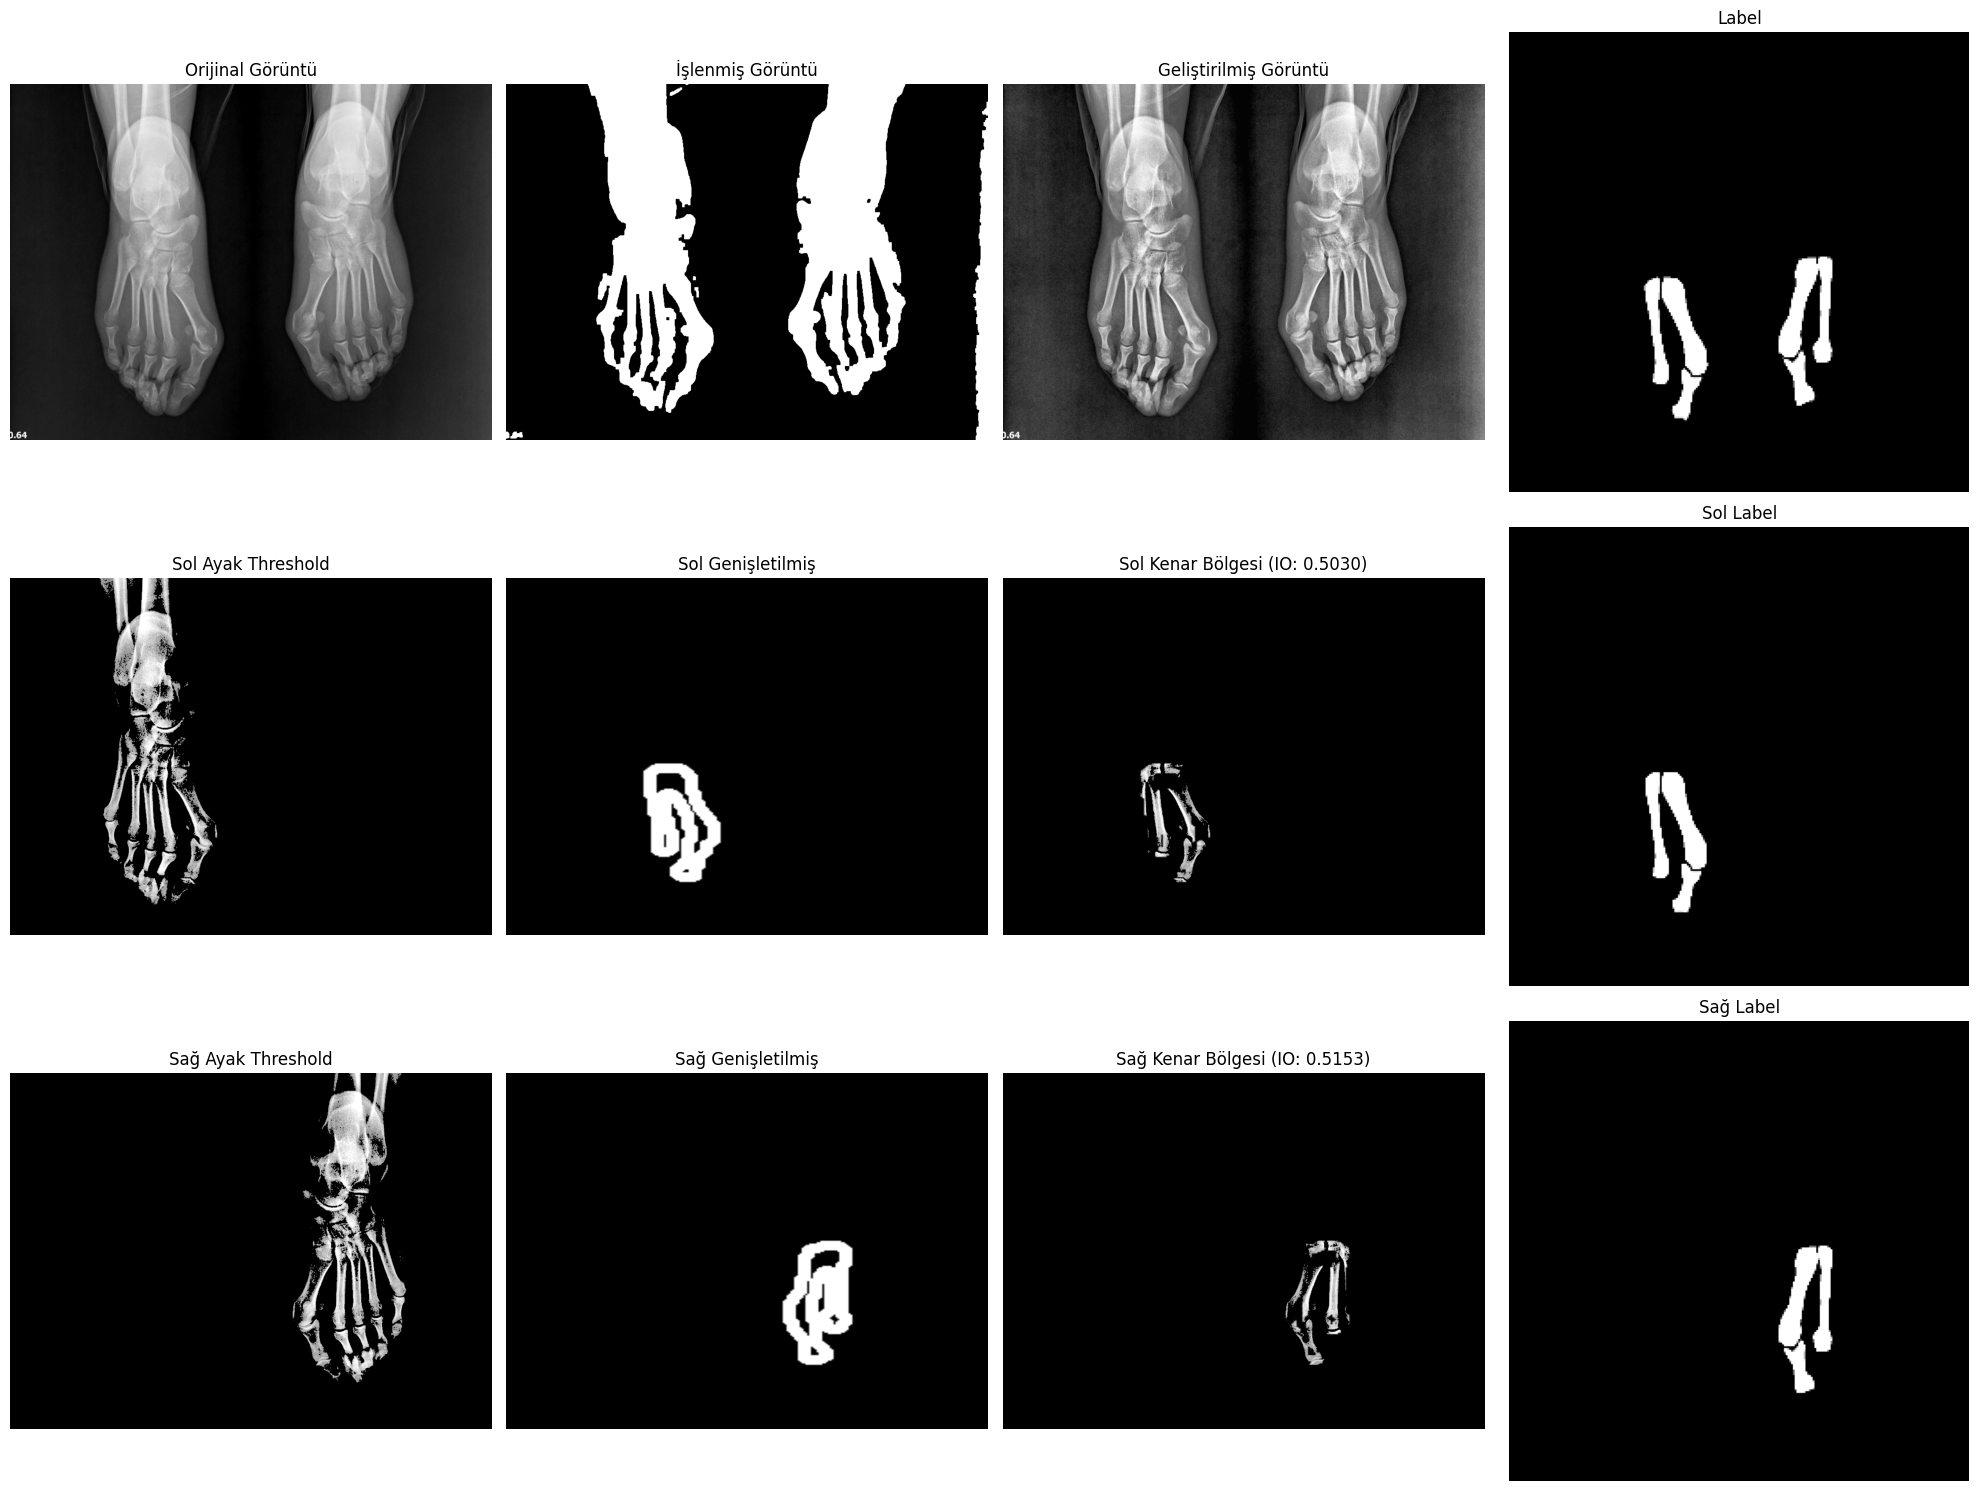


img4 Sonuçları:
Sol Ayak Kenar Bölgesi Ortalama: 2.20
Sağ Ayak Kenar Bölgesi Ortalama: 2.19
Sol Ayak IO Değeri: 0.5030
Sağ Ayak IO Değeri: 0.5153


In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology, measure
from skimage.util import img_as_ubyte
%matplotlib inline

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def preprocess_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    enhanced = apply_clahe(gray)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5,5), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    return opening, enhanced

def find_feet_contours(processed_image):
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    return contours

def separate_feet(image, processed, enhanced):
    contours = find_feet_contours(processed)

    if len(contours) == 2:
        mask1 = np.zeros_like(processed)
        mask2 = np.zeros_like(processed)

        cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
        cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

        foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
        foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

        M1 = cv2.moments(contours[0])
        M2 = cv2.moments(contours[1])

        if M1['m00'] != 0 and M2['m00'] != 0:
            cx1 = int(M1['m10']/M1['m00'])
            cx2 = int(M2['m10']/M2['m00'])

            if cx1 < cx2:
                left_foot = foot1
                right_foot = foot2
            else:
                left_foot = foot2
                right_foot = foot1

            return left_foot, right_foot

    height, width = enhanced.shape[:2]
    left_foot = enhanced[:, :width//2]
    right_foot = enhanced[:, width//2:]

    return left_foot, right_foot

def minmax_norm(image):
    """MinMax normalizasyon"""
    image_float = image.astype(float)
    min_val = np.min(image_float)
    max_val = np.max(image_float)
    if max_val != min_val:
        normalized = (image_float - min_val) / (max_val - min_val) * 255
    else:
        normalized = image_float
    return normalized.astype(np.uint8)

def optimal_image_enhancement(image):
    normalized = minmax_norm(image)
    gaussian = cv2.GaussianBlur(normalized, (3,3), 0.3)
    enhanced_base = cv2.convertScaleAbs(gaussian, alpha=1.05, beta=0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_clahe = clahe.apply(enhanced_base)

    _, threshold = cv2.threshold(enhanced_clahe, 140, 255, cv2.THRESH_TOZERO)

    return threshold

def get_boundary_points(label_image, min_distance=5):
    """
    Label görüntüsünün sınır noktalarını düzenli aralıklarla çıkarır
    """
    binary = label_image > 0
    contours = measure.find_contours(binary, 0.5)

    boundary_points = []
    for contour in contours:
        cumulative_distance = 0
        last_point = None

        for point in contour:
            x, y = np.round(point).astype(int)

            if last_point is None:
                boundary_points.append((x, y))
                last_point = (x, y)
                continue

            distance = np.sqrt((x - last_point[0])**2 + (y - last_point[1])**2)
            cumulative_distance += distance

            if cumulative_distance >= min_distance:
                if 0 <= x < label_image.shape[0] and 0 <= y < label_image.shape[1]:
                    boundary_points.append((x, y))
                cumulative_distance = 0
                last_point = (x, y)

    return np.array(boundary_points)

def get_dilated_boundary(label_image, kernel_size=5):
    """
    Label kenarını dairesel yapısal element ile genişletir
    """
    # Binary görüntüye çevir
    binary = label_image > 0
    boundary = np.zeros_like(label_image)

    # Kenarları bul
    contours = measure.find_contours(binary, 0.5)
    for contour in contours:
        coords = np.round(contour).astype(int)
        for x, y in coords:
            if 0 <= x < boundary.shape[0] and 0 <= y < boundary.shape[1]:
                boundary[x, y] = 255

    # Dairesel yapısal element oluştur
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Genişletme işlemi
    dilated = cv2.dilate(boundary, kernel, iterations=1)

    return dilated

def calculate_io(edge_region, label):
    """
    Kenar bölgesi ile label arasındaki IO değerini hesaplar
    """
    # Görüntü boyutlarını kontrol et ve eşitle
    if edge_region.shape != label.shape:
        edge_region = cv2.resize(edge_region, (label.shape[1], label.shape[0]))

    # Binary görüntülere çevir
    edge_binary = edge_region > 0
    label_binary = label > 0

    # Kesişim ve birleşim
    intersection = np.logical_and(edge_binary, label_binary)
    union = np.logical_or(edge_binary, label_binary)

    # IO hesapla
    if np.sum(union) == 0:
        return 0

    io = np.sum(intersection) / np.sum(union)
    return io

# Ana işlem
# Test görüntüsünü oku
images = {
    'img4': cv2.imread('img4.png', cv2.IMREAD_GRAYSCALE)
}

labels = {
    'label4': cv2.imread('label4.png', cv2.IMREAD_GRAYSCALE)
}

results = {}

# Her görüntü için işlem yap
for (img_name, image), (label_name, label) in zip(images.items(), labels.items()):
    # İşlem adımları
    processed, enhanced = preprocess_image(image)
    left_foot, right_foot = separate_feet(image, processed, enhanced)

    left_threshold = optimal_image_enhancement(left_foot)
    right_threshold = optimal_image_enhancement(right_foot)

    # Label görüntülerini ayır
    processed_label, enhanced_label = preprocess_image(label)
    left_label, right_label = separate_feet(label, processed_label, enhanced_label)

    # Her ayak için genişletilmiş kenarları ve kenar bilgisini hesapla
    left_dilated = get_dilated_boundary(left_label, kernel_size=7)
    right_dilated = get_dilated_boundary(right_label, kernel_size=7)

    # Boyutları kontrol et ve eşitle
    if left_threshold.shape != left_dilated.shape:
        left_dilated = cv2.resize(left_dilated, (left_threshold.shape[1], left_threshold.shape[0]))
    if right_threshold.shape != right_dilated.shape:
        right_dilated = cv2.resize(right_dilated, (right_threshold.shape[1], right_threshold.shape[0]))

    # Threshold görüntüsünü direkt label ile eşleştir
    left_edge_region = cv2.bitwise_and(left_threshold, left_dilated)
    right_edge_region = cv2.bitwise_and(right_threshold, right_dilated)

    # IO değerlerini hesapla
    left_io = calculate_io(left_edge_region, left_label)
    right_io = calculate_io(right_edge_region, right_label)

    results[img_name] = {
        'original': image,
        'left_label': left_label,
        'right_label': right_label,
        'original_label': label,
        'left_dilated': left_dilated,
        'right_dilated': right_dilated,
        'left_edge_region': left_edge_region,
        'right_edge_region': right_edge_region,
        'processed': processed,
        'enhanced': enhanced,
        'left_threshold': left_threshold,
        'right_threshold': right_threshold,
        'left_io': left_io,
        'right_io': right_io
    }

# Görselleştirme
plt.figure(figsize=(20, 15))

for idx, (img_name, result) in enumerate(results.items()):
    # İşlem adımları
    plt.subplot(3, 4, 1)
    plt.imshow(result['original'], cmap='gray')
    plt.title('Orijinal Görüntü')
    plt.axis('off')

    plt.subplot(3, 4, 2)
    plt.imshow(result['processed'], cmap='gray')
    plt.title('İşlenmiş Görüntü')
    plt.axis('off')

    plt.subplot(3, 4, 3)
    plt.imshow(result['enhanced'], cmap='gray')
    plt.title('Geliştirilmiş Görüntü')
    plt.axis('off')

    plt.subplot(3, 4, 4)
    plt.imshow(result['original_label'], cmap='gray')
    plt.title('Label')
    plt.axis('off')

    # Sol ayak sonuçları
    plt.subplot(3, 4, 5)
    plt.imshow(result['left_threshold'], cmap='gray')
    plt.title('Sol Ayak Threshold')
    plt.axis('off')

    plt.subplot(3, 4, 6)
    plt.imshow(result['left_dilated'], cmap='gray')
    plt.title('Sol Genişletilmiş')
    plt.axis('off')

    plt.subplot(3, 4, 7)
    plt.imshow(result['left_edge_region'], cmap='gray')
    plt.title(f'Sol Kenar Bölgesi (IO: {result["left_io"]:.4f})')
    plt.axis('off')

    plt.subplot(3, 4, 8)
    plt.imshow(result['left_label'], cmap='gray')
    plt.title('Sol Label')
    plt.axis('off')

    # Sağ ayak sonuçları
    plt.subplot(3, 4, 9)
    plt.imshow(result['right_threshold'], cmap='gray')
    plt.title('Sağ Ayak Threshold')
    plt.axis('off')

    plt.subplot(3, 4, 10)
    plt.imshow(result['right_dilated'], cmap='gray')
    plt.title('Sağ Genişletilmiş')
    plt.axis('off')

    plt.subplot(3, 4, 11)
    plt.imshow(result['right_edge_region'], cmap='gray')
    plt.title(f'Sağ Kenar Bölgesi (IO: {result["right_io"]:.4f})')
    plt.axis('off')

    plt.subplot(3, 4, 12)
    plt.imshow(result['right_label'], cmap='gray')
    plt.title('Sağ Label')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Sonuçları kaydet
for img_name, result in results.items():
    cv2.imwrite(f'{img_name}_original.png', result['original'])
    cv2.imwrite(f'{img_name}_processed.png', result['processed'])
    cv2.imwrite(f'{img_name}_enhanced.png', result['enhanced'])
    cv2.imwrite(f'{img_name}_original_label.png', result['original_label'])
    cv2.imwrite(f'{img_name}_left_threshold.png', result['left_threshold'])
    cv2.imwrite(f'{img_name}_right_threshold.png', result['right_threshold'])
    cv2.imwrite(f'{img_name}_left_dilated.png', result['left_dilated'])
    cv2.imwrite(f'{img_name}_right_dilated.png', result['right_dilated'])
    cv2.imwrite(f'{img_name}_left_edge_region.png', result['left_edge_region'])
    cv2.imwrite(f'{img_name}_right_edge_region.png', result['right_edge_region'])
    cv2.imwrite(f'{img_name}_left_label.png', result['left_label'])
    cv2.imwrite(f'{img_name}_right_label.png', result['right_label'])

# Ortalama değerleri ve IO değerlerini yazdır
for img_name, result in results.items():
    print(f"\n{img_name} Sonuçları:")
    print(f"Sol Ayak Kenar Bölgesi Ortalama: {np.mean(result['left_edge_region']):.2f}")
    print(f"Sağ Ayak Kenar Bölgesi Ortalama: {np.mean(result['right_edge_region']):.2f}")
    print(f"Sol Ayak IO Değeri: {result['left_io']:.4f}")
    print(f"Sağ Ayak IO Değeri: {result['right_io']:.4f}")

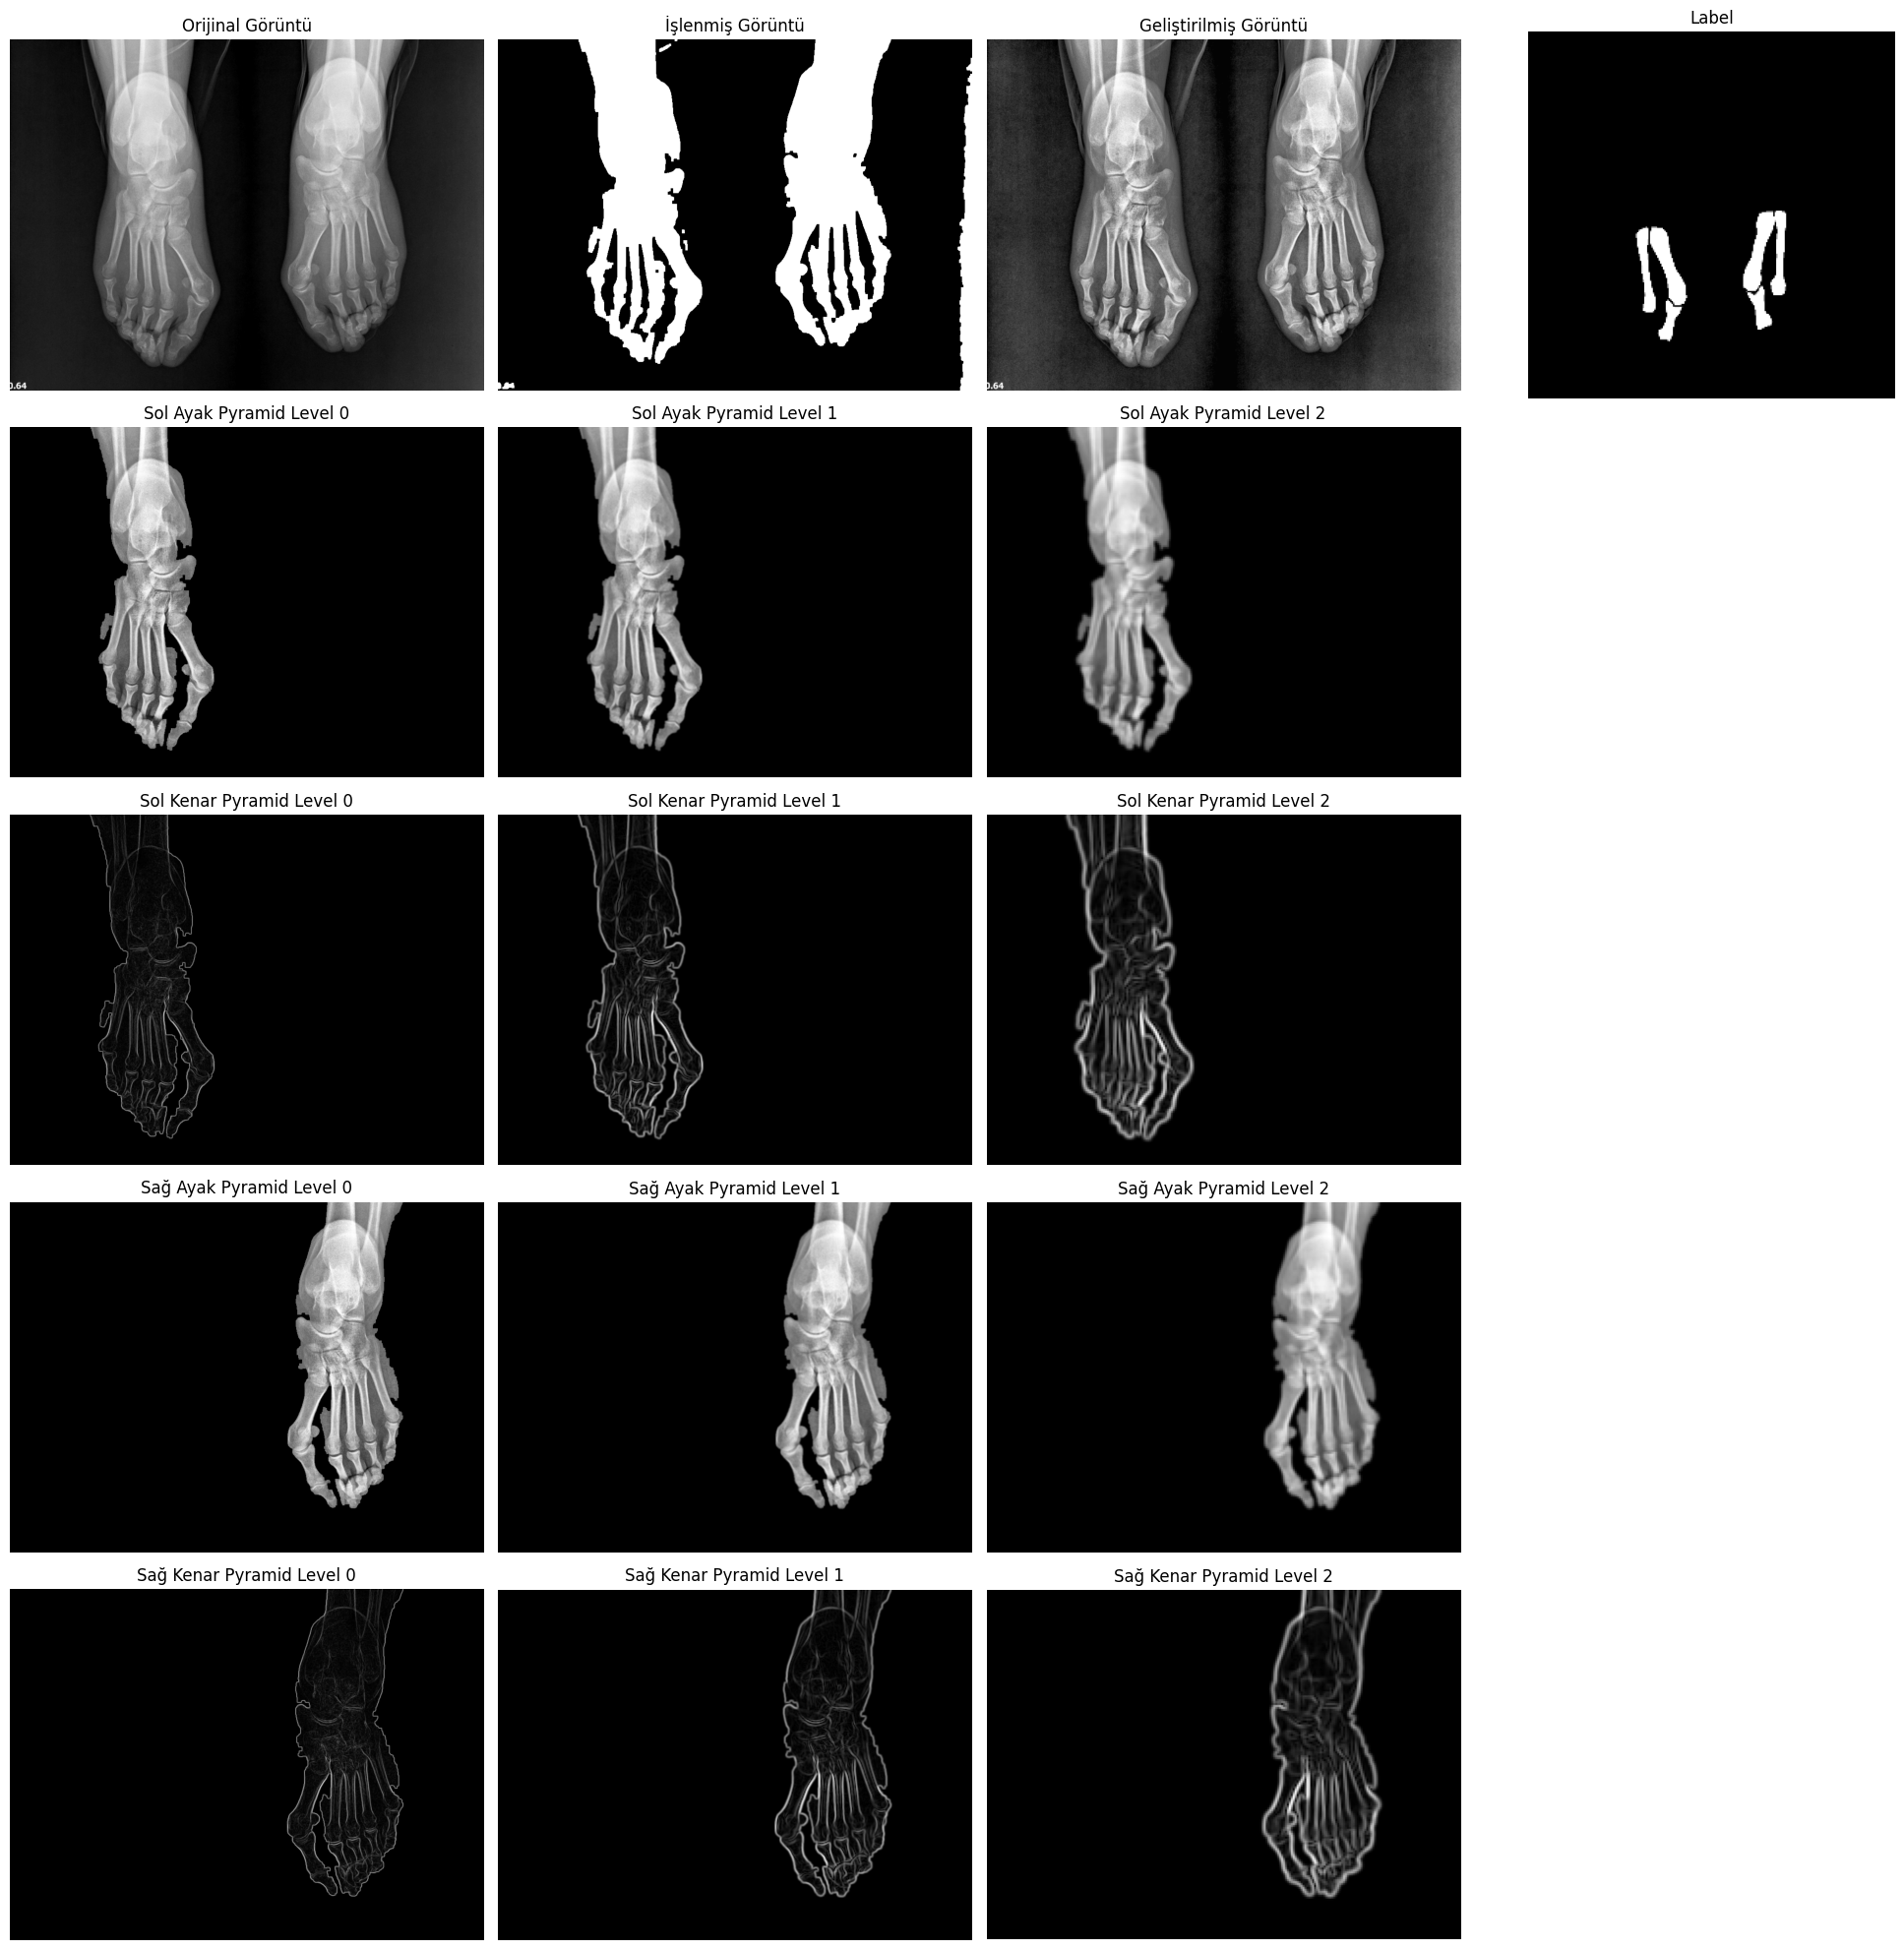


img4 Sonuçları:
Sol Ayak IO Değeri: 0.4593
Sağ Ayak IO Değeri: 0.4739


In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology, measure
from skimage.util import img_as_ubyte
%matplotlib inline

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def preprocess_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    enhanced = apply_clahe(gray)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5,5), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    return opening, enhanced

def find_feet_contours(processed_image):
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    return contours

def separate_feet(image, processed, enhanced):
    contours = find_feet_contours(processed)

    if len(contours) == 2:
        mask1 = np.zeros_like(processed)
        mask2 = np.zeros_like(processed)

        cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
        cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

        foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
        foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

        M1 = cv2.moments(contours[0])
        M2 = cv2.moments(contours[1])

        if M1['m00'] != 0 and M2['m00'] != 0:
            cx1 = int(M1['m10']/M1['m00'])
            cx2 = int(M2['m10']/M2['m00'])

            if cx1 < cx2:
                left_foot = foot1
                right_foot = foot2
            else:
                left_foot = foot2
                right_foot = foot1

            return left_foot, right_foot

    height, width = enhanced.shape[:2]
    left_foot = enhanced[:, :width//2]
    right_foot = enhanced[:, width//2:]

    return left_foot, right_foot

def minmax_norm(image):
    """MinMax normalizasyon"""
    image_float = image.astype(float)
    min_val = np.min(image_float)
    max_val = np.max(image_float)
    if max_val != min_val:
        normalized = (image_float - min_val) / (max_val - min_val) * 255
    else:
        normalized = image_float
    return normalized.astype(np.uint8)

def optimal_image_enhancement(image):
    normalized = minmax_norm(image)
    gaussian = cv2.GaussianBlur(normalized, (3,3), 0.3)
    enhanced_base = cv2.convertScaleAbs(gaussian, alpha=1.05, beta=0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_clahe = clahe.apply(enhanced_base)

    _, threshold = cv2.threshold(enhanced_clahe, 140, 255, cv2.THRESH_TOZERO)

    return threshold

def apply_sobel_k7(image):
    """Sadece Sobel k=7 uygula"""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=7)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=7)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return sobel

def build_gaussian_pyramid(image, levels=3):
    """
    Görüntünün Gauss Pyramid'ini oluşturur
    """
    pyramid = [image]
    for i in range(levels-1):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def get_edge_in_dilated_region_with_pyramid(image, dilated_boundary, levels=3):
    """
    Genişletilmiş bölgedeki kenar bilgisini Gauss Pyramid kullanarak çıkarır
    """
    # Görüntü boyutlarını kontrol et ve eşitle
    if image.shape != dilated_boundary.shape:
        dilated_boundary = cv2.resize(dilated_boundary, (image.shape[1], image.shape[0]))

    # Gauss Pyramid oluştur
    pyramid = build_gaussian_pyramid(image, levels)

    # Her seviye için kenar tespiti yap
    edge_pyramids = []
    for level_img in pyramid:
        # Sobel kenar tespiti
        sobelx = cv2.Sobel(level_img, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(level_img, cv2.CV_64F, 0, 1, ksize=3)
        magnitude = np.sqrt(sobelx**2 + sobely**2)

        # Normalize et
        magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        edge_pyramids.append(magnitude)

    # Pyramid seviyelerini orijinal boyuta getir ve birleştir
    combined_edges = np.zeros_like(image, dtype=np.float32)
    weight = 1.0

    for i, edge_img in enumerate(edge_pyramids):
        # Orijinal boyuta getir
        if i > 0:
            edge_img = cv2.resize(edge_img, (image.shape[1], image.shape[0]))

        # Ağırlıklı toplama
        combined_edges += edge_img * weight
        weight *= 0.5

    # Normalize et
    combined_edges = cv2.normalize(combined_edges, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Genişletilmiş bölge içindeki kenarları al
    edge_in_region = cv2.bitwise_and(combined_edges, dilated_boundary)

    return edge_in_region, pyramid, edge_pyramids

def get_boundary_points(label_image, min_distance=5):
    """
    Label görüntüsünün sınır noktalarını düzenli aralıklarla çıkarır
    """
    binary = label_image > 0
    contours = measure.find_contours(binary, 0.5)

    boundary_points = []
    for contour in contours:
        cumulative_distance = 0
        last_point = None

        for point in contour:
            x, y = np.round(point).astype(int)

            if last_point is None:
                boundary_points.append((x, y))
                last_point = (x, y)
                continue

            distance = np.sqrt((x - last_point[0])**2 + (y - last_point[1])**2)
            cumulative_distance += distance

            if cumulative_distance >= min_distance:
                if 0 <= x < label_image.shape[0] and 0 <= y < label_image.shape[1]:
                    boundary_points.append((x, y))
                cumulative_distance = 0
                last_point = (x, y)

    return np.array(boundary_points)

def get_dilated_boundary(label_image, kernel_size=5):
    """
    Label kenarını dairesel yapısal element ile genişletir
    """
    # Binary görüntüye çevir
    binary = label_image > 0
    boundary = np.zeros_like(label_image)

    # Kenarları bul
    contours = measure.find_contours(binary, 0.5)
    for contour in contours:
        coords = np.round(contour).astype(int)
        for x, y in coords:
            if 0 <= x < boundary.shape[0] and 0 <= y < boundary.shape[1]:
                boundary[x, y] = 255

    # Dairesel yapısal element oluştur
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Genişletme işlemi
    dilated = cv2.dilate(boundary, kernel, iterations=1)

    return dilated

def calculate_io(edge_region, label):
    """
    Kenar bölgesi ile label arasındaki IO değerini hesaplar
    """
    # Görüntü boyutlarını kontrol et ve eşitle
    if edge_region.shape != label.shape:
        edge_region = cv2.resize(edge_region, (label.shape[1], label.shape[0]))

    # Binary görüntülere çevir
    edge_binary = edge_region > 0
    label_binary = label > 0

    # Kesişim ve birleşim
    intersection = np.logical_and(edge_binary, label_binary)
    union = np.logical_or(edge_binary, label_binary)

    # IO hesapla
    if np.sum(union) == 0:
        return 0

    io = np.sum(intersection) / np.sum(union)
    return io

# Ana işlem
# Test görüntüsünü oku
images = {
    'img4': cv2.imread('img4.png', cv2.IMREAD_GRAYSCALE)
}

labels = {
    'label4': cv2.imread('label4.png', cv2.IMREAD_GRAYSCALE)
}

results = {}

# Her görüntü için işlem yap
for (img_name, image), (label_name, label) in zip(images.items(), labels.items()):
    # İşlem adımları
    processed, enhanced = preprocess_image(image)
    left_foot, right_foot = separate_feet(image, processed, enhanced)

    left_threshold = optimal_image_enhancement(left_foot)
    right_threshold = optimal_image_enhancement(right_foot)

    # Label görüntülerini ayır
    processed_label, enhanced_label = preprocess_image(label)
    left_label, right_label = separate_feet(label, processed_label, enhanced_label)

    # Her ayak için genişletilmiş kenarları ve kenar bilgisini hesapla
    left_dilated = get_dilated_boundary(left_label, kernel_size=7)
    right_dilated = get_dilated_boundary(right_label, kernel_size=7)

    # Gauss Pyramid ile kenar tespiti
    left_edge_region, left_pyramid, left_edge_pyramids = get_edge_in_dilated_region_with_pyramid(left_foot, left_dilated)
    right_edge_region, right_pyramid, right_edge_pyramids = get_edge_in_dilated_region_with_pyramid(right_foot, right_dilated)

    # IO değerlerini hesapla
    left_io = calculate_io(left_edge_region, left_label)
    right_io = calculate_io(right_edge_region, right_label)

    results[img_name] = {
        'original': image,
        'left_label': left_label,
        'right_label': right_label,
        'original_label': label,
        'left_dilated': left_dilated,
        'right_dilated': right_dilated,
        'left_edge_region': left_edge_region,
        'right_edge_region': right_edge_region,
        'processed': processed,
        'enhanced': enhanced,
        'left_threshold': left_threshold,
        'right_threshold': right_threshold,
        'left_io': left_io,
        'right_io': right_io,
        'left_pyramid': left_pyramid,
        'right_pyramid': right_pyramid,
        'left_edge_pyramids': left_edge_pyramids,
        'right_edge_pyramids': right_edge_pyramids
    }

# Görselleştirme
plt.figure(figsize=(20, 20))

for idx, (img_name, result) in enumerate(results.items()):
    # Orijinal görüntüler
    plt.subplot(5, 4, 1)
    plt.imshow(result['original'], cmap='gray')
    plt.title('Orijinal Görüntü')
    plt.axis('off')

    plt.subplot(5, 4, 2)
    plt.imshow(result['processed'], cmap='gray')
    plt.title('İşlenmiş Görüntü')
    plt.axis('off')

    plt.subplot(5, 4, 3)
    plt.imshow(result['enhanced'], cmap='gray')
    plt.title('Geliştirilmiş Görüntü')
    plt.axis('off')

    plt.subplot(5, 4, 4)
    plt.imshow(result['original_label'], cmap='gray')
    plt.title('Label')
    plt.axis('off')

    # Sol ayak Gauss Pyramid
    for i in range(len(result['left_pyramid'])):
        plt.subplot(5, 4, 5 + i)
        plt.imshow(result['left_pyramid'][i], cmap='gray')
        plt.title(f'Sol Ayak Pyramid Level {i}')
        plt.axis('off')

    # Sol ayak kenar Pyramid
    for i in range(len(result['left_edge_pyramids'])):
        plt.subplot(5, 4, 9 + i)
        plt.imshow(result['left_edge_pyramids'][i], cmap='gray')
        plt.title(f'Sol Kenar Pyramid Level {i}')
        plt.axis('off')

    # Sağ ayak Gauss Pyramid
    for i in range(len(result['right_pyramid'])):
        plt.subplot(5, 4, 13 + i)
        plt.imshow(result['right_pyramid'][i], cmap='gray')
        plt.title(f'Sağ Ayak Pyramid Level {i}')
        plt.axis('off')

    # Sağ ayak kenar Pyramid
    for i in range(len(result['right_edge_pyramids'])):
        plt.subplot(5, 4, 17 + i)
        plt.imshow(result['right_edge_pyramids'][i], cmap='gray')
        plt.title(f'Sağ Kenar Pyramid Level {i}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# Sonuçları kaydet
for img_name, result in results.items():
    # Orijinal görüntüler
    cv2.imwrite(f'{img_name}_original.png', result['original'])
    cv2.imwrite(f'{img_name}_processed.png', result['processed'])
    cv2.imwrite(f'{img_name}_enhanced.png', result['enhanced'])
    cv2.imwrite(f'{img_name}_original_label.png', result['original_label'])

    # Sol ayak görüntüleri
    for i, pyramid_img in enumerate(result['left_pyramid']):
        cv2.imwrite(f'{img_name}_left_pyramid_level{i}.png', pyramid_img)

    for i, edge_img in enumerate(result['left_edge_pyramids']):
        cv2.imwrite(f'{img_name}_left_edge_pyramid_level{i}.png', edge_img)

    # Sağ ayak görüntüleri
    for i, pyramid_img in enumerate(result['right_pyramid']):
        cv2.imwrite(f'{img_name}_right_pyramid_level{i}.png', pyramid_img)

    for i, edge_img in enumerate(result['right_edge_pyramids']):
        cv2.imwrite(f'{img_name}_right_edge_pyramid_level{i}.png', edge_img)

    cv2.imwrite(f'{img_name}_left_edge_region.png', result['left_edge_region'])
    cv2.imwrite(f'{img_name}_right_edge_region.png', result['right_edge_region'])

# Sonuçları yazdır
for img_name, result in results.items():
    print(f"\n{img_name} Sonuçları:")
    print(f"Sol Ayak IO Değeri: {result['left_io']:.4f}")
    print(f"Sağ Ayak IO Değeri: {result['right_io']:.4f}")